##TabNet

In [1]:
# 다운받은 csv를 pandas의 DataFrame 형식으로 불러옵니다.
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
train=pd.read_csv('/content/drive/MyDrive/credit_prediction/train.csv',sep=',',encoding="cp949")
test=pd.read_csv('/content/drive/MyDrive/credit_prediction/test.csv',sep=',',encoding="cp949")
submission=pd.read_csv('/content/drive/MyDrive/credit_prediction/sample_submission.csv',sep=',',encoding="cp949")

Mounted at /content/drive


##필요한 패키지 설치

In [2]:
!pip3 install pytorch_tabnet
!pip3 install optuna
!pip install catboost
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import precision_score , recall_score , confusion_matrix, accuracy_score
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
from sklearn.model_selection import KFold
import optuna
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import numpy as np
np.random.seed(0)

from tqdm.notebook import tqdm

import os

from matplotlib import pyplot as plt
%matplotlib inline
import torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 599 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 7.0 MB/s 
     |████████████████████████████████| 81 kB 10.0 MB/s 
     |████████████████████████████████| 209 kB 69.3 MB/s 
     |████████████████████████████████| 78 kB 8.3 MB/s 
     |████████████████████████████████| 112 kB 90.8 MB/s 
     |████████████████████████████████| 147 kB 84.8 MB/s 
     |████████████████████████████████| 50 kB 7.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=52ebc14a232b9c9e82e3ad5357e23e101a1e692ecf248992ddacb08b34c720e8
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://u

In [3]:
train = train.drop(['index'], axis=1)
train.fillna('NAN', inplace=True) 
test = test.drop(['index'], axis=1)
test.fillna('NAN', inplace=True)

In [4]:
data=pd.concat([train, test], axis=0)
data.shape

(36457, 19)

(2.544, 18.18]      22460
(18.18, 33.66]      11380
(33.66, 49.14]       2099
(49.14, 64.62]        274
(64.62, 80.1]         165
(80.1, 95.58]          58
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: income_total, dtype: int64


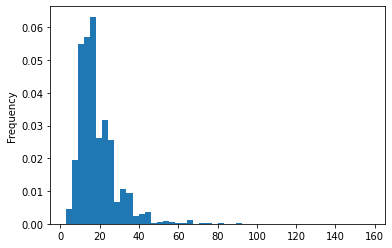

In [5]:
# 마이너스 값 변환
def minus(x):
    return x * -1
data['begin_month'] = data['begin_month'].apply(minus)

data['income_total'] = data['income_total'].astype(object)
data['income_total'] = data['income_total']/10000 
print(data['income_total'].value_counts(bins=10,sort=False))
data['income_total'].plot(kind='hist',bins=50,density=True)

In [6]:
count, bin_dividers =np.histogram(data['income_total'], bins=7)
bin_names=[int(i) for i in range(7) ]
data['income_total']=pd.cut(x=data['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)

data['gender'] = data['gender'].replace(['F','M'],[0,1])
print('gender :')
print(data['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
data['car'] = data['car'].replace(['N','Y'],[0,1])
print(data['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
data['reality'] = data['reality'].replace(['N','Y'],[0,1])
print(data['reality'].value_counts())
print('--------------')
      
print('Having a phone or not: ')
print(data['phone'].value_counts())
print('--------------')
      

print('Having a email or not: ')
print(data['email'].value_counts())
print('--------------')
      

print('Having a work phone or not: ')
print(data['work_phone'].value_counts())
print('--------------')

gender :
0    24430
1    12027
Name: gender, dtype: int64
--------------
Having a car or not : 
0    22614
1    13843
Name: car, dtype: int64
--------------
Having house reality or not: 
1    24506
0    11951
Name: reality, dtype: int64
--------------
Having a phone or not: 
0    25709
1    10748
Name: phone, dtype: int64
--------------
Having a email or not: 
0    33186
1     3271
Name: email, dtype: int64
--------------
Having a work phone or not: 
0    28235
1     8222
Name: work_phone, dtype: int64
--------------


In [7]:
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()
data['income_type']=label_encoder.fit_transform(data['income_type'])
data['edu_type']=label_encoder.fit_transform(data['edu_type'])
data['family_type']=label_encoder.fit_transform(data['family_type'])
data['house_type']=label_encoder.fit_transform(data['house_type'])
data['income_total']=label_encoder.fit_transform(data['income_total'])
data['occyp_type']=label_encoder.fit_transform(data['occyp_type'])
data['credit']=label_encoder.fit_transform(data['credit'])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         36457 non-null  int64  
 1   car            36457 non-null  int64  
 2   reality        36457 non-null  int64  
 3   child_num      36457 non-null  int64  
 4   income_total   36457 non-null  int64  
 5   income_type    36457 non-null  int64  
 6   edu_type       36457 non-null  int64  
 7   family_type    36457 non-null  int64  
 8   house_type     36457 non-null  int64  
 9   DAYS_BIRTH     36457 non-null  int64  
 10  DAYS_EMPLOYED  36457 non-null  int64  
 11  FLAG_MOBIL     36457 non-null  int64  
 12  work_phone     36457 non-null  int64  
 13  phone          36457 non-null  int64  
 14  email          36457 non-null  int64  
 15  occyp_type     36457 non-null  int64  
 16  family_size    36457 non-null  float64
 17  begin_month    36457 non-null  float64
 18  credit 

In [ ]:
train=data[:len(data)-10000]
test=data[len(data)-10000:]
columns=train.columns
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test.drop('credit', axis=1)

In [ ]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in tqdm(train_x.columns):
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train_x[col].nunique())
        l_enc = LabelEncoder()
        train_x[col] = train_x[col].fillna("NaN")
        train_x[col] = l_enc.fit_transform(train_x[col].values)
        try:
            test_x[col] = test_x[col].fillna("NaN")
            test_x[col] = l_enc.transform(test_x[col].values)
        except:
            print(f"Column {col} does not exist in test set")
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        training_mean = train_x.loc[train_x.index, col].mean()
        train.fillna(training_mean, inplace=True)
        test.fillna(training_mean, inplace=True)

  0%|          | 0/18 [00:00<?, ?it/s]

gender 2
car 2
reality 2
child_num 9
income_total 7
income_type 5
edu_type 5
family_type 5
house_type 6
FLAG_MOBIL 1
work_phone 2
phone 2
email 2
occyp_type 19
family_size 10
begin_month 61


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
features = [ col for col in train_x.columns] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [ ]:
train_x=train_x.values
y=train_y.values.flatten()
train_y=train_y.values
test_x=test_x.values

In [ ]:
def Objective(trial):
    
    mask_type = trial.suggest_categorical("mask_type", ["entmax", "sparsemax"])
    n_steps = trial.suggest_int("n_steps", 1, 10, step=1)
    gamma = trial.suggest_float("gamma", 1.0, 2.0, step=0.2)

    tabnet_params = dict(n_steps=n_steps, cat_emb_dim=1,cat_idxs=cat_idxs,cat_dims=cat_dims,
        lambda_sparse=0, optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
        mask_type=mask_type, scheduler_params={'step_size':50,'gamma':gamma},
        scheduler_fn=torch.optim.lr_scheduler.StepLR)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracy=[]
    precision=[]
    recall=[]
    for train_index, test_index in kf.split(train_x,train_y):
        X_train, X_valid = train_x[train_index], train_x[test_index]
        y_train, y_valid = train_y[train_index], train_y[test_index]
        Classifier = TabNetMultiTaskClassifier(**tabnet_params)
        os.environ['WANDB_CONSOLE'] = 'off'
        Classifier.fit(X_train=train_x, y_train=train_y,eval_set=[(X_valid, y_valid)],max_epochs=1000,batch_size=1024,
        patience=50, # please be patient ^^
        virtual_batch_size=128,
        drop_last=False,eval_metric=['accuracy'])
        C=Classifier.predict(X_valid)[0]
        C=list(map(float, C))
        C=list(map(int, C))
        print(np.unique(C))
        print(np.unique(y_valid.flatten()))
        print(confusion_matrix(y_valid.flatten(), C))
        accuracy.append(accuracy_score(y_valid.flatten(),C))
        precision.append(precision_score(y_valid.flatten(), C,average= "macro"))
        recall.append(recall_score(y_valid.flatten(), C,average= "macro"))
        print(accuracy)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(np.mean(accuracy), np.mean(precision), np.mean(recall)))
    return np.mean(accuracy)
study = optuna.create_study(direction="maximize", study_name='TabNet optimization')
study.optimize(Objective, timeout=60*200)

[I 2022-10-30 08:19:30,839] A new study created in memory with name: TabNet optimization
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00385 | val_0_accuracy: 0.62642 |  0:00:02s
epoch 1  | loss: 0.89451 | val_0_accuracy: 0.64116 |  0:00:05s
epoch 2  | loss: 0.8898  | val_0_accuracy: 0.64116 |  0:00:08s
epoch 3  | loss: 0.88726 | val_0_accuracy: 0.64116 |  0:00:11s
epoch 4  | loss: 0.88583 | val_0_accuracy: 0.64116 |  0:00:14s
epoch 5  | loss: 0.88584 | val_0_accuracy: 0.64116 |  0:00:17s
epoch 6  | loss: 0.88276 | val_0_accuracy: 0.64116 |  0:00:20s
epoch 7  | loss: 0.88201 | val_0_accuracy: 0.64116 |  0:00:25s
epoch 8  | loss: 0.88011 | val_0_accuracy: 0.64116 |  0:00:32s
epoch 9  | loss: 0.88058 | val_0_accuracy: 0.64116 |  0:00:35s
epoch 10 | loss: 0.87972 | val_0_accuracy: 0.64116 |  0:00:39s
epoch 11 | loss: 0.87802 | val_0_accuracy: 0.64116 |  0:00:42s
epoch 12 | loss: 0.87784 | val_0_accuracy: 0.64116 |  0:00:45s
epoch 13 | loss: 0.87828 | val_0_accuracy: 0.64116 |  0:00:48s
epoch 14 | loss: 0.87476 | val_0_accuracy: 0.64116 |  0:00:51s
epoch 15 | loss: 0.87024 | val_0_accuracy: 0.6421  |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1 2]
[0. 1. 2.]
[[   0   87  558]
 [   0  331  923]
 [   0   43 3350]]
[0.6955782312925171]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00385 | val_0_accuracy: 0.62434 |  0:00:02s
epoch 1  | loss: 0.89451 | val_0_accuracy: 0.64116 |  0:00:05s
epoch 2  | loss: 0.8898  | val_0_accuracy: 0.64116 |  0:00:08s
epoch 3  | loss: 0.88726 | val_0_accuracy: 0.64116 |  0:00:11s
epoch 4  | loss: 0.88583 | val_0_accuracy: 0.64116 |  0:00:14s
epoch 5  | loss: 0.88584 | val_0_accuracy: 0.64116 |  0:00:16s
epoch 6  | loss: 0.88276 | val_0_accuracy: 0.64116 |  0:00:19s
epoch 7  | loss: 0.88201 | val_0_accuracy: 0.64116 |  0:00:22s
epoch 8  | loss: 0.88011 | val_0_accuracy: 0.64116 |  0:00:25s
epoch 9  | loss: 0.88058 | val_0_accuracy: 0.64116 |  0:00:30s
epoch 10 | loss: 0.87972 | val_0_accuracy: 0.64116 |  0:00:37s
epoch 11 | loss: 0.87802 | val_0_accuracy: 0.64116 |  0:00:39s
epoch 12 | loss: 0.87784 | val_0_accuracy: 0.64116 |  0:00:42s
epoch 13 | loss: 0.87828 | val_0_accuracy: 0.64116 |  0:00:45s
epoch 14 | loss: 0.87476 | val_0_accuracy: 0.64116 |  0:00:48s
epoch 15 | loss: 0.87024 | val_0_accuracy: 0.64153 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1 2]
[0. 1. 2.]
[[   0   74  571]
 [   0  262  992]
 [   0    7 3386]]
[0.6955782312925171, 0.6893424036281179]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00385 | val_0_accuracy: 0.6186  |  0:00:03s
epoch 1  | loss: 0.89451 | val_0_accuracy: 0.64147 |  0:00:06s
epoch 2  | loss: 0.8898  | val_0_accuracy: 0.64147 |  0:00:09s
epoch 3  | loss: 0.88726 | val_0_accuracy: 0.64147 |  0:00:12s
epoch 4  | loss: 0.88583 | val_0_accuracy: 0.64147 |  0:00:15s
epoch 5  | loss: 0.88584 | val_0_accuracy: 0.64147 |  0:00:18s
epoch 6  | loss: 0.88276 | val_0_accuracy: 0.64147 |  0:00:20s
epoch 7  | loss: 0.88201 | val_0_accuracy: 0.64147 |  0:00:23s
epoch 8  | loss: 0.88011 | val_0_accuracy: 0.64147 |  0:00:26s
epoch 9  | loss: 0.88058 | val_0_accuracy: 0.64147 |  0:00:29s
epoch 10 | loss: 0.87972 | val_0_accuracy: 0.64147 |  0:00:32s
epoch 11 | loss: 0.87802 | val_0_accuracy: 0.64147 |  0:00:35s
epoch 12 | loss: 0.87784 | val_0_accuracy: 0.64147 |  0:00:37s
epoch 13 | loss: 0.87828 | val_0_accuracy: 0.64147 |  0:00:40s
epoch 14 | loss: 0.87476 | val_0_accuracy: 0.64147 |  0:00:43s
epoch 15 | loss: 0.87024 | val_0_accuracy: 0.64147 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1 2]
[0. 1. 2.]
[[   0   82  562]
 [   0  280  973]
 [   0   17 3377]]
[0.6955782312925171, 0.6893424036281179, 0.6911736911736912]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00385 | val_0_accuracy: 0.62408 |  0:00:04s
epoch 1  | loss: 0.89451 | val_0_accuracy: 0.64147 |  0:00:09s
epoch 2  | loss: 0.8898  | val_0_accuracy: 0.64147 |  0:00:12s
epoch 3  | loss: 0.88726 | val_0_accuracy: 0.64147 |  0:00:14s
epoch 4  | loss: 0.88583 | val_0_accuracy: 0.64147 |  0:00:17s
epoch 5  | loss: 0.88584 | val_0_accuracy: 0.64147 |  0:00:20s
epoch 6  | loss: 0.88276 | val_0_accuracy: 0.64147 |  0:00:23s
epoch 7  | loss: 0.88201 | val_0_accuracy: 0.64147 |  0:00:26s
epoch 8  | loss: 0.88011 | val_0_accuracy: 0.64147 |  0:00:28s
epoch 9  | loss: 0.88058 | val_0_accuracy: 0.64147 |  0:00:31s
epoch 10 | loss: 0.87972 | val_0_accuracy: 0.64147 |  0:00:34s
epoch 11 | loss: 0.87802 | val_0_accuracy: 0.64147 |  0:00:37s
epoch 12 | loss: 0.87784 | val_0_accuracy: 0.64147 |  0:00:39s
epoch 13 | loss: 0.87828 | val_0_accuracy: 0.64147 |  0:00:42s
epoch 14 | loss: 0.87476 | val_0_accuracy: 0.64147 |  0:00:45s
epoch 15 | loss: 0.87024 | val_0_accuracy: 0.64203 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1 2]
[0. 1. 2.]
[[   0   91  553]
 [   0  271  982]
 [   0    8 3386]]
[0.6955782312925171, 0.6893424036281179, 0.6911736911736912, 0.6911736911736912]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00385 | val_0_accuracy: 0.62578 |  0:00:02s
epoch 1  | loss: 0.89451 | val_0_accuracy: 0.64147 |  0:00:05s
epoch 2  | loss: 0.8898  | val_0_accuracy: 0.64147 |  0:00:08s
epoch 3  | loss: 0.88726 | val_0_accuracy: 0.64147 |  0:00:12s
epoch 4  | loss: 0.88583 | val_0_accuracy: 0.64147 |  0:00:15s
epoch 5  | loss: 0.88584 | val_0_accuracy: 0.64147 |  0:00:18s
epoch 6  | loss: 0.88276 | val_0_accuracy: 0.64147 |  0:00:20s
epoch 7  | loss: 0.88201 | val_0_accuracy: 0.64147 |  0:00:23s
epoch 8  | loss: 0.88011 | val_0_accuracy: 0.64147 |  0:00:26s
epoch 9  | loss: 0.88058 | val_0_accuracy: 0.64147 |  0:00:30s
epoch 10 | loss: 0.87972 | val_0_accuracy: 0.64147 |  0:00:33s
epoch 11 | loss: 0.87802 | val_0_accuracy: 0.64147 |  0:00:35s
epoch 12 | loss: 0.87784 | val_0_accuracy: 0.64147 |  0:00:38s
epoch 13 | loss: 0.87828 | val_0_accuracy: 0.64147 |  0:00:41s
epoch 14 | loss: 0.87476 | val_0_accuracy: 0.64147 |  0:00:44s
epoch 15 | loss: 0.87024 | val_0_accuracy: 0.64203 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-10-30 08:52:18,228] Trial 0 finished with value: 0.6922931422931423 and parameters: {'mask_type': 'sparsemax', 'n_steps': 9, 'gamma': 2.0}. Best is trial 0 with value: 0.6922931422931423.


[1 2]
[0. 1. 2.]
[[   0   76  568]
 [   0  302  951]
 [   0   23 3371]]
[0.6955782312925171, 0.6893424036281179, 0.6911736911736912, 0.6911736911736912, 0.6941976941976942]
정확도: 0.6923, 정밀도: 0.4766, 재현율: 0.4083


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00847 | val_0_accuracy: 0.64116 |  0:00:00s
epoch 1  | loss: 0.8897  | val_0_accuracy: 0.64116 |  0:00:01s
epoch 2  | loss: 0.88339 | val_0_accuracy: 0.64116 |  0:00:02s
epoch 3  | loss: 0.88225 | val_0_accuracy: 0.64116 |  0:00:03s
epoch 4  | loss: 0.88023 | val_0_accuracy: 0.64116 |  0:00:04s
epoch 5  | loss: 0.87751 | val_0_accuracy: 0.64116 |  0:00:04s
epoch 6  | loss: 0.86521 | val_0_accuracy: 0.67177 |  0:00:05s
epoch 7  | loss: 0.83223 | val_0_accuracy: 0.6952  |  0:00:06s
epoch 8  | loss: 0.80944 | val_0_accuracy: 0.69615 |  0:00:07s
epoch 9  | loss: 0.80704 | val_0_accuracy: 0.69293 |  0:00:08s
epoch 10 | loss: 0.80651 | val_0_accuracy: 0.69293 |  0:00:09s
epoch 11 | loss: 0.80495 | val_0_accuracy: 0.69633 |  0:00:10s
epoch 12 | loss: 0.80331 | val_0_accuracy: 0.69671 |  0:00:10s
epoch 13 | loss: 0.80235 | val_0_accuracy: 0.69331 |  0:00:11s
epoch 14 | loss: 0.80199 | val_0_accuracy: 0.69331 |  0:00:12s
epoch 15 | loss: 0.80036 | val_0_accuracy: 0.69293 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[0 1 2]
[0. 1. 2.]
[[  31   99  515]
 [   6  473  775]
 [  14   75 3304]]
[0.7195767195767195]


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00847 | val_0_accuracy: 0.64116 |  0:00:00s
epoch 1  | loss: 0.8897  | val_0_accuracy: 0.64116 |  0:00:01s
epoch 2  | loss: 0.88339 | val_0_accuracy: 0.64116 |  0:00:02s
epoch 3  | loss: 0.88225 | val_0_accuracy: 0.64116 |  0:00:03s
epoch 4  | loss: 0.88023 | val_0_accuracy: 0.64116 |  0:00:04s
epoch 5  | loss: 0.87751 | val_0_accuracy: 0.64116 |  0:00:04s
epoch 6  | loss: 0.86521 | val_0_accuracy: 0.66497 |  0:00:05s
epoch 7  | loss: 0.83223 | val_0_accuracy: 0.6867  |  0:00:06s
epoch 8  | loss: 0.80944 | val_0_accuracy: 0.68613 |  0:00:07s
epoch 9  | loss: 0.80704 | val_0_accuracy: 0.68896 |  0:00:08s
epoch 10 | loss: 0.80651 | val_0_accuracy: 0.68896 |  0:00:09s
epoch 11 | loss: 0.80495 | val_0_accuracy: 0.68821 |  0:00:09s
epoch 12 | loss: 0.80331 | val_0_accuracy: 0.6867  |  0:00:10s
epoch 13 | loss: 0.80235 | val_0_accuracy: 0.68896 |  0:00:11s
epoch 14 | loss: 0.80199 | val_0_accuracy: 0.68915 |  0:00:12s
epoch 15 | loss: 0.80036 | val_0_accuracy: 0.68878 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[0 1 2]
[0. 1. 2.]
[[  47  104  494]
 [   3  464  787]
 [  24   96 3273]]
[0.7195767195767195, 0.7150415721844293]


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00847 | val_0_accuracy: 0.64147 |  0:00:00s
epoch 1  | loss: 0.8897  | val_0_accuracy: 0.64147 |  0:00:01s
epoch 2  | loss: 0.88339 | val_0_accuracy: 0.64147 |  0:00:02s
epoch 3  | loss: 0.88225 | val_0_accuracy: 0.64147 |  0:00:03s
epoch 4  | loss: 0.88023 | val_0_accuracy: 0.64147 |  0:00:04s
epoch 5  | loss: 0.87751 | val_0_accuracy: 0.64147 |  0:00:04s
epoch 6  | loss: 0.86521 | val_0_accuracy: 0.66982 |  0:00:05s
epoch 7  | loss: 0.83223 | val_0_accuracy: 0.68909 |  0:00:06s
epoch 8  | loss: 0.80944 | val_0_accuracy: 0.68928 |  0:00:07s
epoch 9  | loss: 0.80704 | val_0_accuracy: 0.69004 |  0:00:07s
epoch 10 | loss: 0.80651 | val_0_accuracy: 0.69004 |  0:00:08s
epoch 11 | loss: 0.80495 | val_0_accuracy: 0.68928 |  0:00:09s
epoch 12 | loss: 0.80331 | val_0_accuracy: 0.68872 |  0:00:10s
epoch 13 | loss: 0.80235 | val_0_accuracy: 0.68985 |  0:00:10s
epoch 14 | loss: 0.80199 | val_0_accuracy: 0.69136 |  0:00:11s
epoch 15 | loss: 0.80036 | val_0_accuracy: 0.6908  |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[0 1 2]
[0. 1. 2.]
[[  55  116  473]
 [  10  513  730]
 [  18  128 3248]]
[0.7195767195767195, 0.7150415721844293, 0.7212247212247213]


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00847 | val_0_accuracy: 0.64147 |  0:00:00s
epoch 1  | loss: 0.8897  | val_0_accuracy: 0.64147 |  0:00:01s
epoch 2  | loss: 0.88339 | val_0_accuracy: 0.64147 |  0:00:02s
epoch 3  | loss: 0.88225 | val_0_accuracy: 0.64147 |  0:00:03s
epoch 4  | loss: 0.88023 | val_0_accuracy: 0.64147 |  0:00:04s
epoch 5  | loss: 0.87751 | val_0_accuracy: 0.64147 |  0:00:05s
epoch 6  | loss: 0.86521 | val_0_accuracy: 0.67152 |  0:00:06s
epoch 7  | loss: 0.83223 | val_0_accuracy: 0.69155 |  0:00:07s
epoch 8  | loss: 0.80944 | val_0_accuracy: 0.68947 |  0:00:08s
epoch 9  | loss: 0.80704 | val_0_accuracy: 0.69023 |  0:00:09s
epoch 10 | loss: 0.80651 | val_0_accuracy: 0.69023 |  0:00:10s
epoch 11 | loss: 0.80495 | val_0_accuracy: 0.68966 |  0:00:11s
epoch 12 | loss: 0.80331 | val_0_accuracy: 0.69061 |  0:00:12s
epoch 13 | loss: 0.80235 | val_0_accuracy: 0.69042 |  0:00:13s
epoch 14 | loss: 0.80199 | val_0_accuracy: 0.69023 |  0:00:13s
epoch 15 | loss: 0.80036 | val_0_accuracy: 0.68928 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[0 1 2]
[0. 1. 2.]
[[  49  107  488]
 [  12  444  797]
 [  26   77 3291]]
[0.7195767195767195, 0.7150415721844293, 0.7212247212247213, 0.7151767151767152]


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00847 | val_0_accuracy: 0.64147 |  0:00:00s
epoch 1  | loss: 0.8897  | val_0_accuracy: 0.64147 |  0:00:01s
epoch 2  | loss: 0.88339 | val_0_accuracy: 0.64147 |  0:00:02s
epoch 3  | loss: 0.88225 | val_0_accuracy: 0.64147 |  0:00:03s
epoch 4  | loss: 0.88023 | val_0_accuracy: 0.64147 |  0:00:04s
epoch 5  | loss: 0.87751 | val_0_accuracy: 0.64147 |  0:00:04s
epoch 6  | loss: 0.86521 | val_0_accuracy: 0.66849 |  0:00:05s
epoch 7  | loss: 0.83223 | val_0_accuracy: 0.69269 |  0:00:06s
epoch 8  | loss: 0.80944 | val_0_accuracy: 0.69325 |  0:00:07s
epoch 9  | loss: 0.80704 | val_0_accuracy: 0.6925  |  0:00:07s
epoch 10 | loss: 0.80651 | val_0_accuracy: 0.6925  |  0:00:08s
epoch 11 | loss: 0.80495 | val_0_accuracy: 0.69363 |  0:00:09s
epoch 12 | loss: 0.80331 | val_0_accuracy: 0.6942  |  0:00:10s
epoch 13 | loss: 0.80235 | val_0_accuracy: 0.69212 |  0:00:11s
epoch 14 | loss: 0.80199 | val_0_accuracy: 0.69439 |  0:00:12s
epoch 15 | loss: 0.80036 | val_0_accuracy: 0.69269 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2022-10-30 09:06:47,781] Trial 1 finished with value: 0.7179196893482608 and parameters: {'mask_type': 'entmax', 'n_steps': 1, 'gamma': 1.4}. Best is trial 1 with value: 0.7179196893482608.


[0 1 2]
[0. 1. 2.]
[[  44  109  491]
 [   4  520  729]
 [  23  133 3238]]
[0.7195767195767195, 0.7150415721844293, 0.7212247212247213, 0.7151767151767152, 0.7185787185787186]
정확도: 0.7179, 정밀도: 0.6799, 재현율: 0.4731


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.92886 | val_0_accuracy: 0.58768 |  0:00:01s
epoch 1  | loss: 0.88615 | val_0_accuracy: 0.64116 |  0:00:02s
epoch 2  | loss: 0.87857 | val_0_accuracy: 0.64116 |  0:00:03s
epoch 3  | loss: 0.87344 | val_0_accuracy: 0.64607 |  0:00:05s
epoch 4  | loss: 0.86219 | val_0_accuracy: 0.66856 |  0:00:06s
epoch 5  | loss: 0.85313 | val_0_accuracy: 0.67082 |  0:00:07s
epoch 6  | loss: 0.84347 | val_0_accuracy: 0.68613 |  0:00:09s
epoch 7  | loss: 0.83272 | val_0_accuracy: 0.68726 |  0:00:10s
epoch 8  | loss: 0.82936 | val_0_accuracy: 0.68821 |  0:00:11s
epoch 9  | loss: 0.82299 | val_0_accuracy: 0.68707 |  0:00:13s
epoch 10 | loss: 0.82158 | val_0_accuracy: 0.68575 |  0:00:14s
epoch 11 | loss: 0.8186  | val_0_accuracy: 0.69085 |  0:00:15s
epoch 12 | loss: 0.81905 | val_0_accuracy: 0.69463 |  0:00:17s
epoch 13 | loss: 0.8174  | val_0_accuracy: 0.69085 |  0:00:18s
epoch 14 | loss: 0.81692 | val_0_accuracy: 0.69123 |  0:00:19s
epoch 15 | loss: 0.81606 | val_0_accuracy: 0.69048 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1 2]
[0. 1. 2.]
[[   0   84  561]
 [   0  317  937]
 [   0   26 3367]]
[0.6961451247165533]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.92886 | val_0_accuracy: 0.5788  |  0:00:01s
epoch 1  | loss: 0.88615 | val_0_accuracy: 0.64116 |  0:00:02s
epoch 2  | loss: 0.87857 | val_0_accuracy: 0.64116 |  0:00:03s
epoch 3  | loss: 0.87344 | val_0_accuracy: 0.64361 |  0:00:05s
epoch 4  | loss: 0.86219 | val_0_accuracy: 0.65684 |  0:00:06s
epoch 5  | loss: 0.85313 | val_0_accuracy: 0.66686 |  0:00:07s
epoch 6  | loss: 0.84347 | val_0_accuracy: 0.68235 |  0:00:09s
epoch 7  | loss: 0.83272 | val_0_accuracy: 0.68292 |  0:00:11s
epoch 8  | loss: 0.82936 | val_0_accuracy: 0.68367 |  0:00:12s
epoch 9  | loss: 0.82299 | val_0_accuracy: 0.68348 |  0:00:13s
epoch 10 | loss: 0.82158 | val_0_accuracy: 0.68292 |  0:00:14s
epoch 11 | loss: 0.8186  | val_0_accuracy: 0.68632 |  0:00:16s
epoch 12 | loss: 0.81905 | val_0_accuracy: 0.68632 |  0:00:17s
epoch 13 | loss: 0.8174  | val_0_accuracy: 0.68594 |  0:00:18s
epoch 14 | loss: 0.81692 | val_0_accuracy: 0.68575 |  0:00:20s
epoch 15 | loss: 0.81606 | val_0_accuracy: 0.68651 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1 2]
[0. 1. 2.]
[[   0   75  570]
 [   0  265  989]
 [   0    8 3385]]
[0.6961451247165533, 0.6897203325774754]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.92886 | val_0_accuracy: 0.57399 |  0:00:01s
epoch 1  | loss: 0.88615 | val_0_accuracy: 0.64147 |  0:00:02s
epoch 2  | loss: 0.87857 | val_0_accuracy: 0.64147 |  0:00:04s
epoch 3  | loss: 0.87344 | val_0_accuracy: 0.64884 |  0:00:05s
epoch 4  | loss: 0.86219 | val_0_accuracy: 0.66226 |  0:00:06s
epoch 5  | loss: 0.85313 | val_0_accuracy: 0.6666  |  0:00:08s
epoch 6  | loss: 0.84347 | val_0_accuracy: 0.6838  |  0:00:09s
epoch 7  | loss: 0.83272 | val_0_accuracy: 0.68475 |  0:00:10s
epoch 8  | loss: 0.82936 | val_0_accuracy: 0.68588 |  0:00:12s
epoch 9  | loss: 0.82299 | val_0_accuracy: 0.68588 |  0:00:13s
epoch 10 | loss: 0.82158 | val_0_accuracy: 0.68569 |  0:00:14s
epoch 11 | loss: 0.8186  | val_0_accuracy: 0.68891 |  0:00:15s
epoch 12 | loss: 0.81905 | val_0_accuracy: 0.68909 |  0:00:17s
epoch 13 | loss: 0.8174  | val_0_accuracy: 0.68777 |  0:00:18s
epoch 14 | loss: 0.81692 | val_0_accuracy: 0.68891 |  0:00:19s
epoch 15 | loss: 0.81606 | val_0_accuracy: 0.68853 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1 2]
[0. 1. 2.]
[[   0   75  569]
 [   0  266  987]
 [   0    2 3392]]
[0.6961451247165533, 0.6897203325774754, 0.6913626913626914]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.92886 | val_0_accuracy: 0.58061 |  0:00:01s
epoch 1  | loss: 0.88615 | val_0_accuracy: 0.64147 |  0:00:02s
epoch 2  | loss: 0.87857 | val_0_accuracy: 0.64147 |  0:00:04s
epoch 3  | loss: 0.87344 | val_0_accuracy: 0.64562 |  0:00:05s
epoch 4  | loss: 0.86219 | val_0_accuracy: 0.66056 |  0:00:06s
epoch 5  | loss: 0.85313 | val_0_accuracy: 0.66679 |  0:00:08s
epoch 6  | loss: 0.84347 | val_0_accuracy: 0.68418 |  0:00:09s
epoch 7  | loss: 0.83272 | val_0_accuracy: 0.68342 |  0:00:10s
epoch 8  | loss: 0.82936 | val_0_accuracy: 0.68513 |  0:00:11s
epoch 9  | loss: 0.82299 | val_0_accuracy: 0.68626 |  0:00:13s
epoch 10 | loss: 0.82158 | val_0_accuracy: 0.68683 |  0:00:14s
epoch 11 | loss: 0.8186  | val_0_accuracy: 0.68815 |  0:00:15s
epoch 12 | loss: 0.81905 | val_0_accuracy: 0.68928 |  0:00:17s
epoch 13 | loss: 0.8174  | val_0_accuracy: 0.68796 |  0:00:18s
epoch 14 | loss: 0.81692 | val_0_accuracy: 0.68834 |  0:00:19s
epoch 15 | loss: 0.81606 | val_0_accuracy: 0.68796 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1 2]
[0. 1. 2.]
[[   0   89  555]
 [   0  274  979]
 [   0   11 3383]]
[0.6961451247165533, 0.6897203325774754, 0.6913626913626914, 0.6911736911736912]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.92886 | val_0_accuracy: 0.57569 |  0:00:01s
epoch 1  | loss: 0.88615 | val_0_accuracy: 0.64147 |  0:00:02s
epoch 2  | loss: 0.87857 | val_0_accuracy: 0.64147 |  0:00:03s
epoch 3  | loss: 0.87344 | val_0_accuracy: 0.64544 |  0:00:05s
epoch 4  | loss: 0.86219 | val_0_accuracy: 0.66207 |  0:00:06s
epoch 5  | loss: 0.85313 | val_0_accuracy: 0.66812 |  0:00:07s
epoch 6  | loss: 0.84347 | val_0_accuracy: 0.6872  |  0:00:09s
epoch 7  | loss: 0.83272 | val_0_accuracy: 0.68588 |  0:00:10s
epoch 8  | loss: 0.82936 | val_0_accuracy: 0.68739 |  0:00:11s
epoch 9  | loss: 0.82299 | val_0_accuracy: 0.68683 |  0:00:13s
epoch 10 | loss: 0.82158 | val_0_accuracy: 0.68683 |  0:00:14s
epoch 11 | loss: 0.8186  | val_0_accuracy: 0.68909 |  0:00:15s
epoch 12 | loss: 0.81905 | val_0_accuracy: 0.69117 |  0:00:17s
epoch 13 | loss: 0.8174  | val_0_accuracy: 0.68928 |  0:00:18s
epoch 14 | loss: 0.81692 | val_0_accuracy: 0.6908  |  0:00:19s
epoch 15 | loss: 0.81606 | val_0_accuracy: 0.68985 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-10-30 09:19:44,137] Trial 2 finished with value: 0.6925577068434212 and parameters: {'mask_type': 'sparsemax', 'n_steps': 3, 'gamma': 1.6}. Best is trial 1 with value: 0.7179196893482608.


[1 2]
[0. 1. 2.]
[[   0   81  563]
 [   0  330  923]
 [   0   50 3344]]
[0.6961451247165533, 0.6897203325774754, 0.6913626913626914, 0.6911736911736912, 0.6943866943866944]
정확도: 0.6926, 정밀도: 0.4780, 재현율: 0.4087


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.09487 | val_0_accuracy: 0.63757 |  0:00:02s
epoch 1  | loss: 0.90466 | val_0_accuracy: 0.59713 |  0:00:05s
epoch 2  | loss: 0.89165 | val_0_accuracy: 0.64116 |  0:00:07s
epoch 3  | loss: 0.88839 | val_0_accuracy: 0.64116 |  0:00:10s
epoch 4  | loss: 0.88954 | val_0_accuracy: 0.64116 |  0:00:12s
epoch 5  | loss: 0.88507 | val_0_accuracy: 0.64116 |  0:00:15s
epoch 6  | loss: 0.88368 | val_0_accuracy: 0.64116 |  0:00:18s
epoch 7  | loss: 0.88384 | val_0_accuracy: 0.64116 |  0:00:20s
epoch 8  | loss: 0.88542 | val_0_accuracy: 0.64116 |  0:00:23s
epoch 9  | loss: 0.88504 | val_0_accuracy: 0.64116 |  0:00:25s
epoch 10 | loss: 0.88394 | val_0_accuracy: 0.64116 |  0:00:28s
epoch 11 | loss: 0.88192 | val_0_accuracy: 0.64116 |  0:00:31s
epoch 12 | loss: 0.88107 | val_0_accuracy: 0.64116 |  0:00:33s
epoch 13 | loss: 0.88013 | val_0_accuracy: 0.64116 |  0:00:36s
epoch 14 | loss: 0.88095 | val_0_accuracy: 0.64116 |  0:00:38s
epoch 15 | loss: 0.87966 | val_0_accuracy: 0.64116 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1 2]
[0. 1. 2.]
[[   0   71  574]
 [   0  274  980]
 [   0    2 3391]]
[0.6925547996976569]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.09487 | val_0_accuracy: 0.63643 |  0:00:02s
epoch 1  | loss: 0.90466 | val_0_accuracy: 0.5958  |  0:00:05s
epoch 2  | loss: 0.89165 | val_0_accuracy: 0.64116 |  0:00:07s
epoch 3  | loss: 0.88839 | val_0_accuracy: 0.64116 |  0:00:10s
epoch 4  | loss: 0.88954 | val_0_accuracy: 0.64116 |  0:00:12s
epoch 5  | loss: 0.88507 | val_0_accuracy: 0.64116 |  0:00:15s
epoch 6  | loss: 0.88368 | val_0_accuracy: 0.64116 |  0:00:18s
epoch 7  | loss: 0.88384 | val_0_accuracy: 0.64116 |  0:00:20s
epoch 8  | loss: 0.88542 | val_0_accuracy: 0.64116 |  0:00:23s
epoch 9  | loss: 0.88504 | val_0_accuracy: 0.64116 |  0:00:26s
epoch 10 | loss: 0.88394 | val_0_accuracy: 0.64116 |  0:00:28s
epoch 11 | loss: 0.88192 | val_0_accuracy: 0.64116 |  0:00:31s
epoch 12 | loss: 0.88107 | val_0_accuracy: 0.64116 |  0:00:35s
epoch 13 | loss: 0.88013 | val_0_accuracy: 0.64116 |  0:00:37s
epoch 14 | loss: 0.88095 | val_0_accuracy: 0.64116 |  0:00:40s
epoch 15 | loss: 0.87966 | val_0_accuracy: 0.64116 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1 2]
[0. 1. 2.]
[[   0   72  573]
 [   0  257  997]
 [   0    7 3386]]
[0.6925547996976569, 0.6883975812547242]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.09487 | val_0_accuracy: 0.63523 |  0:00:02s
epoch 1  | loss: 0.90466 | val_0_accuracy: 0.58628 |  0:00:05s
epoch 2  | loss: 0.89165 | val_0_accuracy: 0.64147 |  0:00:07s
epoch 3  | loss: 0.88839 | val_0_accuracy: 0.64147 |  0:00:10s
epoch 4  | loss: 0.88954 | val_0_accuracy: 0.64147 |  0:00:12s
epoch 5  | loss: 0.88507 | val_0_accuracy: 0.64147 |  0:00:15s
epoch 6  | loss: 0.88368 | val_0_accuracy: 0.64147 |  0:00:18s
epoch 7  | loss: 0.88384 | val_0_accuracy: 0.64147 |  0:00:20s
epoch 8  | loss: 0.88542 | val_0_accuracy: 0.64147 |  0:00:23s
epoch 9  | loss: 0.88504 | val_0_accuracy: 0.64147 |  0:00:26s
epoch 10 | loss: 0.88394 | val_0_accuracy: 0.64147 |  0:00:28s
epoch 11 | loss: 0.88192 | val_0_accuracy: 0.64147 |  0:00:31s
epoch 12 | loss: 0.88107 | val_0_accuracy: 0.64147 |  0:00:33s
epoch 13 | loss: 0.88013 | val_0_accuracy: 0.64147 |  0:00:36s
epoch 14 | loss: 0.88095 | val_0_accuracy: 0.64147 |  0:00:38s
epoch 15 | loss: 0.87966 | val_0_accuracy: 0.64147 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1 2]
[0. 1. 2.]
[[   0   74  570]
 [   0  256  997]
 [   0    1 3393]]
[0.6925547996976569, 0.6883975812547242, 0.6896616896616896]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.09487 | val_0_accuracy: 0.63636 |  0:00:02s
epoch 1  | loss: 0.90466 | val_0_accuracy: 0.59667 |  0:00:06s
epoch 2  | loss: 0.89165 | val_0_accuracy: 0.64147 |  0:00:09s
epoch 3  | loss: 0.88839 | val_0_accuracy: 0.64147 |  0:00:12s
epoch 4  | loss: 0.88954 | val_0_accuracy: 0.64147 |  0:00:14s
epoch 5  | loss: 0.88507 | val_0_accuracy: 0.64147 |  0:00:17s
epoch 6  | loss: 0.88368 | val_0_accuracy: 0.64147 |  0:00:19s
epoch 7  | loss: 0.88384 | val_0_accuracy: 0.64147 |  0:00:22s
epoch 8  | loss: 0.88542 | val_0_accuracy: 0.64147 |  0:00:25s
epoch 9  | loss: 0.88504 | val_0_accuracy: 0.64147 |  0:00:27s
epoch 10 | loss: 0.88394 | val_0_accuracy: 0.64147 |  0:00:30s
epoch 11 | loss: 0.88192 | val_0_accuracy: 0.64147 |  0:00:32s
epoch 12 | loss: 0.88107 | val_0_accuracy: 0.64147 |  0:00:35s
epoch 13 | loss: 0.88013 | val_0_accuracy: 0.64147 |  0:00:37s
epoch 14 | loss: 0.88095 | val_0_accuracy: 0.64147 |  0:00:40s
epoch 15 | loss: 0.87966 | val_0_accuracy: 0.64147 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1 2]
[0. 1. 2.]
[[   0   86  558]
 [   0  258  995]
 [   0    2 3392]]
[0.6925547996976569, 0.6883975812547242, 0.6896616896616896, 0.6898506898506899]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.09487 | val_0_accuracy: 0.63617 |  0:00:02s
epoch 1  | loss: 0.90466 | val_0_accuracy: 0.58458 |  0:00:05s
epoch 2  | loss: 0.89165 | val_0_accuracy: 0.64147 |  0:00:07s
epoch 3  | loss: 0.88839 | val_0_accuracy: 0.64147 |  0:00:10s
epoch 4  | loss: 0.88954 | val_0_accuracy: 0.64147 |  0:00:12s
epoch 5  | loss: 0.88507 | val_0_accuracy: 0.64147 |  0:00:15s
epoch 6  | loss: 0.88368 | val_0_accuracy: 0.64147 |  0:00:17s
epoch 7  | loss: 0.88384 | val_0_accuracy: 0.64147 |  0:00:20s
epoch 8  | loss: 0.88542 | val_0_accuracy: 0.64147 |  0:00:22s
epoch 9  | loss: 0.88504 | val_0_accuracy: 0.64147 |  0:00:25s
epoch 10 | loss: 0.88394 | val_0_accuracy: 0.64147 |  0:00:28s
epoch 11 | loss: 0.88192 | val_0_accuracy: 0.64147 |  0:00:30s
epoch 12 | loss: 0.88107 | val_0_accuracy: 0.64147 |  0:00:33s
epoch 13 | loss: 0.88013 | val_0_accuracy: 0.64147 |  0:00:35s
epoch 14 | loss: 0.88095 | val_0_accuracy: 0.64147 |  0:00:38s
epoch 15 | loss: 0.87966 | val_0_accuracy: 0.64147 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-10-30 09:40:43,485] Trial 3 finished with value: 0.6905166905166904 and parameters: {'mask_type': 'sparsemax', 'n_steps': 8, 'gamma': 1.0}. Best is trial 1 with value: 0.7179196893482608.


[1 2]
[0. 1. 2.]
[[   0   70  574]
 [   0  271  982]
 [   0    3 3391]]
[0.6925547996976569, 0.6883975812547242, 0.6896616896616896, 0.6898506898506899, 0.6921186921186921]
정확도: 0.6905, 정밀도: 0.4857, 재현율: 0.4030


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.9289  | val_0_accuracy: 0.63927 |  0:00:01s
epoch 1  | loss: 0.88305 | val_0_accuracy: 0.58787 |  0:00:02s
epoch 2  | loss: 0.88006 | val_0_accuracy: 0.64116 |  0:00:03s
epoch 3  | loss: 0.87632 | val_0_accuracy: 0.64116 |  0:00:05s
epoch 4  | loss: 0.87466 | val_0_accuracy: 0.64116 |  0:00:06s
epoch 5  | loss: 0.86722 | val_0_accuracy: 0.64116 |  0:00:08s
epoch 6  | loss: 0.85669 | val_0_accuracy: 0.67309 |  0:00:09s
epoch 7  | loss: 0.83643 | val_0_accuracy: 0.68178 |  0:00:10s
epoch 8  | loss: 0.83154 | val_0_accuracy: 0.67498 |  0:00:11s
epoch 9  | loss: 0.82349 | val_0_accuracy: 0.685   |  0:00:13s
epoch 10 | loss: 0.8225  | val_0_accuracy: 0.68537 |  0:00:14s
epoch 11 | loss: 0.82075 | val_0_accuracy: 0.68972 |  0:00:15s
epoch 12 | loss: 0.81819 | val_0_accuracy: 0.68802 |  0:00:17s
epoch 13 | loss: 0.81746 | val_0_accuracy: 0.69067 |  0:00:18s
epoch 14 | loss: 0.81598 | val_0_accuracy: 0.69067 |  0:00:20s
epoch 15 | loss: 0.81501 | val_0_accuracy: 0.69142 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[0 1 2]
[0. 1. 2.]
[[  70   91  484]
 [  40  432  782]
 [  30   72 3291]]
[0.7167422524565382]


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.9289  | val_0_accuracy: 0.64002 |  0:00:01s
epoch 1  | loss: 0.88305 | val_0_accuracy: 0.5873  |  0:00:02s
epoch 2  | loss: 0.88006 | val_0_accuracy: 0.64116 |  0:00:03s
epoch 3  | loss: 0.87632 | val_0_accuracy: 0.64116 |  0:00:05s
epoch 4  | loss: 0.87466 | val_0_accuracy: 0.64116 |  0:00:06s
epoch 5  | loss: 0.86722 | val_0_accuracy: 0.64116 |  0:00:08s
epoch 6  | loss: 0.85669 | val_0_accuracy: 0.67158 |  0:00:10s
epoch 7  | loss: 0.83643 | val_0_accuracy: 0.67876 |  0:00:12s
epoch 8  | loss: 0.83154 | val_0_accuracy: 0.67196 |  0:00:13s
epoch 9  | loss: 0.82349 | val_0_accuracy: 0.68292 |  0:00:14s
epoch 10 | loss: 0.8225  | val_0_accuracy: 0.68462 |  0:00:16s
epoch 11 | loss: 0.82075 | val_0_accuracy: 0.68726 |  0:00:17s
epoch 12 | loss: 0.81819 | val_0_accuracy: 0.68519 |  0:00:19s
epoch 13 | loss: 0.81746 | val_0_accuracy: 0.68575 |  0:00:20s
epoch 14 | loss: 0.81598 | val_0_accuracy: 0.68632 |  0:00:22s
epoch 15 | loss: 0.81501 | val_0_accuracy: 0.68537 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[0 1 2]
[0. 1. 2.]
[[  39  108  498]
 [  17  466  771]
 [  13  102 3278]]
[0.7167422524565382, 0.7148526077097506]


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.9289  | val_0_accuracy: 0.6392  |  0:00:01s
epoch 1  | loss: 0.88305 | val_0_accuracy: 0.58401 |  0:00:02s
epoch 2  | loss: 0.88006 | val_0_accuracy: 0.64147 |  0:00:03s
epoch 3  | loss: 0.87632 | val_0_accuracy: 0.64147 |  0:00:05s
epoch 4  | loss: 0.87466 | val_0_accuracy: 0.64147 |  0:00:06s
epoch 5  | loss: 0.86722 | val_0_accuracy: 0.64147 |  0:00:08s
epoch 6  | loss: 0.85669 | val_0_accuracy: 0.67511 |  0:00:09s
epoch 7  | loss: 0.83643 | val_0_accuracy: 0.68324 |  0:00:10s
epoch 8  | loss: 0.83154 | val_0_accuracy: 0.67303 |  0:00:12s
epoch 9  | loss: 0.82349 | val_0_accuracy: 0.68475 |  0:00:13s
epoch 10 | loss: 0.8225  | val_0_accuracy: 0.68588 |  0:00:14s
epoch 11 | loss: 0.82075 | val_0_accuracy: 0.6872  |  0:00:16s
epoch 12 | loss: 0.81819 | val_0_accuracy: 0.68531 |  0:00:17s
epoch 13 | loss: 0.81746 | val_0_accuracy: 0.68891 |  0:00:18s
epoch 14 | loss: 0.81598 | val_0_accuracy: 0.68796 |  0:00:19s
epoch 15 | loss: 0.81501 | val_0_accuracy: 0.6872  |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[0 1 2]
[0. 1. 2.]
[[  41  102  501]
 [   5  458  790]
 [   7   79 3308]]
[0.7167422524565382, 0.7148526077097506, 0.7195237195237195]


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.9289  | val_0_accuracy: 0.63958 |  0:00:01s
epoch 1  | loss: 0.88305 | val_0_accuracy: 0.58741 |  0:00:02s
epoch 2  | loss: 0.88006 | val_0_accuracy: 0.64147 |  0:00:04s
epoch 3  | loss: 0.87632 | val_0_accuracy: 0.64147 |  0:00:05s
epoch 4  | loss: 0.87466 | val_0_accuracy: 0.64147 |  0:00:06s
epoch 5  | loss: 0.86722 | val_0_accuracy: 0.64147 |  0:00:07s
epoch 6  | loss: 0.85669 | val_0_accuracy: 0.67397 |  0:00:09s
epoch 7  | loss: 0.83643 | val_0_accuracy: 0.68116 |  0:00:10s
epoch 8  | loss: 0.83154 | val_0_accuracy: 0.67303 |  0:00:11s
epoch 9  | loss: 0.82349 | val_0_accuracy: 0.68494 |  0:00:13s
epoch 10 | loss: 0.8225  | val_0_accuracy: 0.68626 |  0:00:14s
epoch 11 | loss: 0.82075 | val_0_accuracy: 0.6872  |  0:00:15s
epoch 12 | loss: 0.81819 | val_0_accuracy: 0.68494 |  0:00:17s
epoch 13 | loss: 0.81746 | val_0_accuracy: 0.68777 |  0:00:18s
epoch 14 | loss: 0.81598 | val_0_accuracy: 0.68739 |  0:00:19s
epoch 15 | loss: 0.81501 | val_0_accuracy: 0.68531 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[0 1 2]
[0. 1. 2.]
[[  55   96  493]
 [  18  415  820]
 [  10   76 3308]]
[0.7167422524565382, 0.7148526077097506, 0.7195237195237195, 0.714042714042714]


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.9289  | val_0_accuracy: 0.6409  |  0:00:01s
epoch 1  | loss: 0.88305 | val_0_accuracy: 0.59516 |  0:00:02s
epoch 2  | loss: 0.88006 | val_0_accuracy: 0.64147 |  0:00:04s
epoch 3  | loss: 0.87632 | val_0_accuracy: 0.64147 |  0:00:05s
epoch 4  | loss: 0.87466 | val_0_accuracy: 0.64147 |  0:00:06s
epoch 5  | loss: 0.86722 | val_0_accuracy: 0.64147 |  0:00:08s
epoch 6  | loss: 0.85669 | val_0_accuracy: 0.67549 |  0:00:09s
epoch 7  | loss: 0.83643 | val_0_accuracy: 0.6821  |  0:00:11s
epoch 8  | loss: 0.83154 | val_0_accuracy: 0.67208 |  0:00:12s
epoch 9  | loss: 0.82349 | val_0_accuracy: 0.68267 |  0:00:13s
epoch 10 | loss: 0.8225  | val_0_accuracy: 0.68513 |  0:00:15s
epoch 11 | loss: 0.82075 | val_0_accuracy: 0.69061 |  0:00:16s
epoch 12 | loss: 0.81819 | val_0_accuracy: 0.68815 |  0:00:17s
epoch 13 | loss: 0.81746 | val_0_accuracy: 0.68928 |  0:00:18s
epoch 14 | loss: 0.81598 | val_0_accuracy: 0.68928 |  0:00:20s
epoch 15 | loss: 0.81501 | val_0_accuracy: 0.68909 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2022-10-30 10:12:45,476] Trial 4 finished with value: 0.7163700020842878 and parameters: {'mask_type': 'entmax', 'n_steps': 3, 'gamma': 1.2}. Best is trial 1 with value: 0.7179196893482608.


[0 1 2]
[0. 1. 2.]
[[  62   77  505]
 [  23  406  824]
 [  17   53 3324]]
[0.7167422524565382, 0.7148526077097506, 0.7195237195237195, 0.714042714042714, 0.7166887166887167]
정확도: 0.7164, 정밀도: 0.6866, 재현율: 0.4677


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.31057 | val_0_accuracy: 0.6164  |  0:00:03s
epoch 1  | loss: 0.9186  | val_0_accuracy: 0.63209 |  0:00:06s
epoch 2  | loss: 0.90005 | val_0_accuracy: 0.64078 |  0:00:09s
epoch 3  | loss: 0.89148 | val_0_accuracy: 0.64116 |  0:00:12s
epoch 4  | loss: 0.88545 | val_0_accuracy: 0.64116 |  0:00:15s
epoch 5  | loss: 0.8839  | val_0_accuracy: 0.64116 |  0:00:18s
epoch 6  | loss: 0.88441 | val_0_accuracy: 0.64116 |  0:00:21s
epoch 7  | loss: 0.88396 | val_0_accuracy: 0.64116 |  0:00:25s
epoch 8  | loss: 0.8845  | val_0_accuracy: 0.64116 |  0:00:28s
epoch 9  | loss: 0.88018 | val_0_accuracy: 0.64116 |  0:00:31s
epoch 10 | loss: 0.8807  | val_0_accuracy: 0.64116 |  0:00:34s
epoch 11 | loss: 0.8803  | val_0_accuracy: 0.64116 |  0:00:37s
epoch 12 | loss: 0.88255 | val_0_accuracy: 0.64116 |  0:00:40s
epoch 13 | loss: 0.88163 | val_0_accuracy: 0.64116 |  0:00:43s
epoch 14 | loss: 0.88059 | val_0_accuracy: 0.64116 |  0:00:46s
epoch 15 | loss: 0.87972 | val_0_accuracy: 0.64116 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1 2]
[0. 1. 2.]
[[   0   87  558]
 [   0  330  924]
 [   0   43 3350]]
[0.6953892668178382]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.31057 | val_0_accuracy: 0.61848 |  0:00:03s
epoch 1  | loss: 0.9186  | val_0_accuracy: 0.63416 |  0:00:06s
epoch 2  | loss: 0.90005 | val_0_accuracy: 0.64078 |  0:00:09s
epoch 3  | loss: 0.89148 | val_0_accuracy: 0.64116 |  0:00:12s
epoch 4  | loss: 0.88545 | val_0_accuracy: 0.64116 |  0:00:15s
epoch 5  | loss: 0.8839  | val_0_accuracy: 0.64116 |  0:00:18s
epoch 6  | loss: 0.88441 | val_0_accuracy: 0.64116 |  0:00:22s
epoch 7  | loss: 0.88396 | val_0_accuracy: 0.64116 |  0:00:25s
epoch 8  | loss: 0.8845  | val_0_accuracy: 0.64116 |  0:00:28s
epoch 9  | loss: 0.88018 | val_0_accuracy: 0.64116 |  0:00:31s
epoch 10 | loss: 0.8807  | val_0_accuracy: 0.64116 |  0:00:34s
epoch 11 | loss: 0.8803  | val_0_accuracy: 0.64116 |  0:00:38s
epoch 12 | loss: 0.88255 | val_0_accuracy: 0.64116 |  0:00:41s
epoch 13 | loss: 0.88163 | val_0_accuracy: 0.64116 |  0:00:44s
epoch 14 | loss: 0.88059 | val_0_accuracy: 0.64116 |  0:00:47s
epoch 15 | loss: 0.87972 | val_0_accuracy: 0.64116 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[0 1 2]
[0. 1. 2.]
[[   1   72  572]
 [   0  260  994]
 [   0    7 3386]]
[0.6953892668178382, 0.6891534391534392]


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.31057 | val_0_accuracy: 0.61406 |  0:00:03s
epoch 1  | loss: 0.9186  | val_0_accuracy: 0.63372 |  0:00:06s
epoch 2  | loss: 0.90005 | val_0_accuracy: 0.64033 |  0:00:09s
epoch 3  | loss: 0.89148 | val_0_accuracy: 0.64147 |  0:00:12s
epoch 4  | loss: 0.88545 | val_0_accuracy: 0.64147 |  0:00:15s
epoch 5  | loss: 0.8839  | val_0_accuracy: 0.64147 |  0:00:18s
epoch 6  | loss: 0.88441 | val_0_accuracy: 0.64147 |  0:00:21s
epoch 7  | loss: 0.88396 | val_0_accuracy: 0.64147 |  0:00:25s
epoch 8  | loss: 0.8845  | val_0_accuracy: 0.64147 |  0:00:28s
epoch 9  | loss: 0.88018 | val_0_accuracy: 0.64147 |  0:00:31s
epoch 10 | loss: 0.8807  | val_0_accuracy: 0.64147 |  0:00:34s
epoch 11 | loss: 0.8803  | val_0_accuracy: 0.64147 |  0:00:37s
epoch 12 | loss: 0.88255 | val_0_accuracy: 0.64147 |  0:00:40s
epoch 13 | loss: 0.88163 | val_0_accuracy: 0.64147 |  0:00:43s
epoch 14 | loss: 0.88059 | val_0_accuracy: 0.64147 |  0:00:46s
epoch 15 | loss: 0.87972 | val_0_accuracy: 0.64147 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1 2]
[0. 1. 2.]
[[   0   79  565]
 [   0  277  976]
 [   0   16 3378]]
[0.6953892668178382, 0.6891534391534392, 0.6907956907956908]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.31057 | val_0_accuracy: 0.61179 |  0:00:04s
epoch 1  | loss: 0.9186  | val_0_accuracy: 0.62918 |  0:00:08s
epoch 2  | loss: 0.90005 | val_0_accuracy: 0.64166 |  0:00:12s
epoch 3  | loss: 0.89148 | val_0_accuracy: 0.64147 |  0:00:15s
epoch 4  | loss: 0.88545 | val_0_accuracy: 0.64147 |  0:00:19s
epoch 5  | loss: 0.8839  | val_0_accuracy: 0.64147 |  0:00:22s
epoch 6  | loss: 0.88441 | val_0_accuracy: 0.64147 |  0:00:25s
epoch 7  | loss: 0.88396 | val_0_accuracy: 0.64147 |  0:00:28s
epoch 8  | loss: 0.8845  | val_0_accuracy: 0.64147 |  0:00:31s
epoch 9  | loss: 0.88018 | val_0_accuracy: 0.64147 |  0:00:34s
epoch 10 | loss: 0.8807  | val_0_accuracy: 0.64147 |  0:00:37s
epoch 11 | loss: 0.8803  | val_0_accuracy: 0.64147 |  0:00:41s
epoch 12 | loss: 0.88255 | val_0_accuracy: 0.64147 |  0:00:44s
epoch 13 | loss: 0.88163 | val_0_accuracy: 0.64147 |  0:00:47s
epoch 14 | loss: 0.88059 | val_0_accuracy: 0.64147 |  0:00:50s
epoch 15 | loss: 0.87972 | val_0_accuracy: 0.64147 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1 2]
[0. 1. 2.]
[[   0   86  558]
 [   0  261  992]
 [   0    2 3392]]
[0.6953892668178382, 0.6891534391534392, 0.6907956907956908, 0.6904176904176904]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.31057 | val_0_accuracy: 0.61501 |  0:00:03s
epoch 1  | loss: 0.9186  | val_0_accuracy: 0.63145 |  0:00:06s
epoch 2  | loss: 0.90005 | val_0_accuracy: 0.6409  |  0:00:09s
epoch 3  | loss: 0.89148 | val_0_accuracy: 0.64147 |  0:00:12s
epoch 4  | loss: 0.88545 | val_0_accuracy: 0.64147 |  0:00:15s
epoch 5  | loss: 0.8839  | val_0_accuracy: 0.64147 |  0:00:18s
epoch 6  | loss: 0.88441 | val_0_accuracy: 0.64147 |  0:00:22s
epoch 7  | loss: 0.88396 | val_0_accuracy: 0.64147 |  0:00:25s
epoch 8  | loss: 0.8845  | val_0_accuracy: 0.64147 |  0:00:29s
epoch 9  | loss: 0.88018 | val_0_accuracy: 0.64147 |  0:00:32s
epoch 10 | loss: 0.8807  | val_0_accuracy: 0.64147 |  0:00:35s
epoch 11 | loss: 0.8803  | val_0_accuracy: 0.64147 |  0:00:38s
epoch 12 | loss: 0.88255 | val_0_accuracy: 0.64147 |  0:00:41s
epoch 13 | loss: 0.88163 | val_0_accuracy: 0.64147 |  0:00:44s
epoch 14 | loss: 0.88059 | val_0_accuracy: 0.64147 |  0:00:47s
epoch 15 | loss: 0.87972 | val_0_accuracy: 0.64147 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-10-30 10:51:01,177] Trial 5 finished with value: 0.6918773561630703 and parameters: {'mask_type': 'entmax', 'n_steps': 10, 'gamma': 2.0}. Best is trial 1 with value: 0.7179196893482608.


[1 2]
[0. 1. 2.]
[[   0   79  565]
 [   0  324  929]
 [   0   48 3346]]
[0.6953892668178382, 0.6891534391534392, 0.6907956907956908, 0.6904176904176904, 0.6936306936306936]
정확도: 0.6919, 정밀도: 0.5424, 재현율: 0.4084


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.99567 | val_0_accuracy: 0.63738 |  0:00:02s
epoch 1  | loss: 0.90359 | val_0_accuracy: 0.64116 |  0:00:05s
epoch 2  | loss: 0.88876 | val_0_accuracy: 0.64116 |  0:00:08s
epoch 3  | loss: 0.88664 | val_0_accuracy: 0.64116 |  0:00:11s
epoch 4  | loss: 0.88438 | val_0_accuracy: 0.64116 |  0:00:14s
epoch 5  | loss: 0.88312 | val_0_accuracy: 0.64116 |  0:00:17s
epoch 6  | loss: 0.88393 | val_0_accuracy: 0.64116 |  0:00:20s
epoch 7  | loss: 0.88289 | val_0_accuracy: 0.64116 |  0:00:23s
epoch 8  | loss: 0.88128 | val_0_accuracy: 0.64116 |  0:00:26s
epoch 9  | loss: 0.87923 | val_0_accuracy: 0.64116 |  0:00:29s
epoch 10 | loss: 0.87824 | val_0_accuracy: 0.64116 |  0:00:31s
epoch 11 | loss: 0.87651 | val_0_accuracy: 0.64116 |  0:00:34s
epoch 12 | loss: 0.873   | val_0_accuracy: 0.64116 |  0:00:37s
epoch 13 | loss: 0.86807 | val_0_accuracy: 0.64172 |  0:00:40s
epoch 14 | loss: 0.84786 | val_0_accuracy: 0.69539 |  0:00:43s
epoch 15 | loss: 0.82735 | val_0_accuracy: 0.69199 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1 2]
[0. 1. 2.]
[[   0   87  558]
 [   0  329  925]
 [   0   42 3351]]
[0.6953892668178382]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.99567 | val_0_accuracy: 0.637   |  0:00:02s
epoch 1  | loss: 0.90359 | val_0_accuracy: 0.64116 |  0:00:05s
epoch 2  | loss: 0.88876 | val_0_accuracy: 0.64116 |  0:00:08s
epoch 3  | loss: 0.88664 | val_0_accuracy: 0.64116 |  0:00:11s
epoch 4  | loss: 0.88438 | val_0_accuracy: 0.64116 |  0:00:15s
epoch 5  | loss: 0.88312 | val_0_accuracy: 0.64116 |  0:00:17s
epoch 6  | loss: 0.88393 | val_0_accuracy: 0.64116 |  0:00:21s
epoch 7  | loss: 0.88289 | val_0_accuracy: 0.64116 |  0:00:24s
epoch 8  | loss: 0.88128 | val_0_accuracy: 0.64116 |  0:00:27s
epoch 9  | loss: 0.87923 | val_0_accuracy: 0.64116 |  0:00:30s
epoch 10 | loss: 0.87824 | val_0_accuracy: 0.64116 |  0:00:33s
epoch 11 | loss: 0.87651 | val_0_accuracy: 0.64116 |  0:00:36s
epoch 12 | loss: 0.873   | val_0_accuracy: 0.64116 |  0:00:39s
epoch 13 | loss: 0.86807 | val_0_accuracy: 0.64172 |  0:00:41s
epoch 14 | loss: 0.84786 | val_0_accuracy: 0.68537 |  0:00:44s
epoch 15 | loss: 0.82735 | val_0_accuracy: 0.68764 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1 2]
[0. 1. 2.]
[[   0   79  566]
 [   0  270  984]
 [   0   14 3379]]
[0.6953892668178382, 0.6895313681027967]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.99567 | val_0_accuracy: 0.63825 |  0:00:02s
epoch 1  | loss: 0.90359 | val_0_accuracy: 0.64147 |  0:00:05s
epoch 2  | loss: 0.88876 | val_0_accuracy: 0.64147 |  0:00:08s
epoch 3  | loss: 0.88664 | val_0_accuracy: 0.64147 |  0:00:11s
epoch 4  | loss: 0.88438 | val_0_accuracy: 0.64147 |  0:00:14s
epoch 5  | loss: 0.88312 | val_0_accuracy: 0.64147 |  0:00:17s
epoch 6  | loss: 0.88393 | val_0_accuracy: 0.64147 |  0:00:20s
epoch 7  | loss: 0.88289 | val_0_accuracy: 0.64147 |  0:00:23s
epoch 8  | loss: 0.88128 | val_0_accuracy: 0.64147 |  0:00:26s
epoch 9  | loss: 0.87923 | val_0_accuracy: 0.64147 |  0:00:29s
epoch 10 | loss: 0.87824 | val_0_accuracy: 0.64147 |  0:00:31s
epoch 11 | loss: 0.87651 | val_0_accuracy: 0.64147 |  0:00:34s
epoch 12 | loss: 0.873   | val_0_accuracy: 0.64147 |  0:00:37s
epoch 13 | loss: 0.86807 | val_0_accuracy: 0.64147 |  0:00:40s
epoch 14 | loss: 0.84786 | val_0_accuracy: 0.68928 |  0:00:43s
epoch 15 | loss: 0.82735 | val_0_accuracy: 0.68947 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1 2]
[0. 1. 2.]
[[   0   76  568]
 [   0  269  984]
 [   0    8 3386]]
[0.6953892668178382, 0.6895313681027967, 0.6907956907956908]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.99567 | val_0_accuracy: 0.63977 |  0:00:03s
epoch 1  | loss: 0.90359 | val_0_accuracy: 0.64147 |  0:00:05s
epoch 2  | loss: 0.88876 | val_0_accuracy: 0.64147 |  0:00:08s
epoch 3  | loss: 0.88664 | val_0_accuracy: 0.64147 |  0:00:12s
epoch 4  | loss: 0.88438 | val_0_accuracy: 0.64147 |  0:00:15s
epoch 5  | loss: 0.88312 | val_0_accuracy: 0.64147 |  0:00:18s
epoch 6  | loss: 0.88393 | val_0_accuracy: 0.64147 |  0:00:21s
epoch 7  | loss: 0.88289 | val_0_accuracy: 0.64147 |  0:00:24s
epoch 8  | loss: 0.88128 | val_0_accuracy: 0.64147 |  0:00:27s
epoch 9  | loss: 0.87923 | val_0_accuracy: 0.64147 |  0:00:30s
epoch 10 | loss: 0.87824 | val_0_accuracy: 0.64147 |  0:00:33s
epoch 11 | loss: 0.87651 | val_0_accuracy: 0.64147 |  0:00:35s
epoch 12 | loss: 0.873   | val_0_accuracy: 0.64147 |  0:00:38s
epoch 13 | loss: 0.86807 | val_0_accuracy: 0.64166 |  0:00:41s
epoch 14 | loss: 0.84786 | val_0_accuracy: 0.68947 |  0:00:44s
epoch 15 | loss: 0.82735 | val_0_accuracy: 0.69042 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1 2]
[0. 1. 2.]
[[   0   87  557]
 [   0  265  988]
 [   0    2 3392]]
[0.6953892668178382, 0.6895313681027967, 0.6907956907956908, 0.6911736911736912]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.99567 | val_0_accuracy: 0.6392  |  0:00:02s
epoch 1  | loss: 0.90359 | val_0_accuracy: 0.64147 |  0:00:05s
epoch 2  | loss: 0.88876 | val_0_accuracy: 0.64147 |  0:00:08s
epoch 3  | loss: 0.88664 | val_0_accuracy: 0.64147 |  0:00:11s
epoch 4  | loss: 0.88438 | val_0_accuracy: 0.64147 |  0:00:14s
epoch 5  | loss: 0.88312 | val_0_accuracy: 0.64147 |  0:00:16s
epoch 6  | loss: 0.88393 | val_0_accuracy: 0.64147 |  0:00:19s
epoch 7  | loss: 0.88289 | val_0_accuracy: 0.64147 |  0:00:22s
epoch 8  | loss: 0.88128 | val_0_accuracy: 0.64147 |  0:00:25s
epoch 9  | loss: 0.87923 | val_0_accuracy: 0.64147 |  0:00:28s
epoch 10 | loss: 0.87824 | val_0_accuracy: 0.64147 |  0:00:31s
epoch 11 | loss: 0.87651 | val_0_accuracy: 0.64147 |  0:00:34s
epoch 12 | loss: 0.873   | val_0_accuracy: 0.64147 |  0:00:36s
epoch 13 | loss: 0.86807 | val_0_accuracy: 0.64222 |  0:00:39s
epoch 14 | loss: 0.84786 | val_0_accuracy: 0.69344 |  0:00:42s
epoch 15 | loss: 0.82735 | val_0_accuracy: 0.69193 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-10-30 11:12:57,920] Trial 6 finished with value: 0.6920663420663421 and parameters: {'mask_type': 'entmax', 'n_steps': 9, 'gamma': 2.0}. Best is trial 1 with value: 0.7179196893482608.


[1 2]
[0. 1. 2.]
[[   0   81  563]
 [   0  329  924]
 [   0   54 3340]]
[0.6953892668178382, 0.6895313681027967, 0.6907956907956908, 0.6911736911736912, 0.6934416934416935]
정확도: 0.6921, 정밀도: 0.4750, 재현율: 0.4087


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.11766 | val_0_accuracy: 0.58522 |  0:00:02s
epoch 1  | loss: 0.90469 | val_0_accuracy: 0.64116 |  0:00:05s
epoch 2  | loss: 0.89237 | val_0_accuracy: 0.64116 |  0:00:08s
epoch 3  | loss: 0.88488 | val_0_accuracy: 0.64116 |  0:00:10s
epoch 4  | loss: 0.88491 | val_0_accuracy: 0.64116 |  0:00:13s
epoch 5  | loss: 0.88381 | val_0_accuracy: 0.64116 |  0:00:15s
epoch 6  | loss: 0.88105 | val_0_accuracy: 0.64116 |  0:00:18s
epoch 7  | loss: 0.88032 | val_0_accuracy: 0.64116 |  0:00:21s
epoch 8  | loss: 0.88249 | val_0_accuracy: 0.64116 |  0:00:23s
epoch 9  | loss: 0.88081 | val_0_accuracy: 0.64116 |  0:00:26s
epoch 10 | loss: 0.87839 | val_0_accuracy: 0.64116 |  0:00:28s
epoch 11 | loss: 0.87698 | val_0_accuracy: 0.64116 |  0:00:31s
epoch 12 | loss: 0.8748  | val_0_accuracy: 0.64116 |  0:00:34s
epoch 13 | loss: 0.87254 | val_0_accuracy: 0.64116 |  0:00:37s
epoch 14 | loss: 0.86643 | val_0_accuracy: 0.66459 |  0:00:39s
epoch 15 | loss: 0.84788 | val_0_accuracy: 0.68726 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1 2]
[0. 1. 2.]
[[   0   79  566]
 [   0  299  955]
 [   0   15 3378]]
[0.6948223733938019]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.11766 | val_0_accuracy: 0.5856  |  0:00:02s
epoch 1  | loss: 0.90469 | val_0_accuracy: 0.64116 |  0:00:05s
epoch 2  | loss: 0.89237 | val_0_accuracy: 0.64116 |  0:00:07s
epoch 3  | loss: 0.88488 | val_0_accuracy: 0.64116 |  0:00:10s
epoch 4  | loss: 0.88491 | val_0_accuracy: 0.64116 |  0:00:13s
epoch 5  | loss: 0.88381 | val_0_accuracy: 0.64116 |  0:00:16s
epoch 6  | loss: 0.88105 | val_0_accuracy: 0.64116 |  0:00:18s
epoch 7  | loss: 0.88032 | val_0_accuracy: 0.64116 |  0:00:21s
epoch 8  | loss: 0.88249 | val_0_accuracy: 0.64116 |  0:00:24s
epoch 9  | loss: 0.88081 | val_0_accuracy: 0.64116 |  0:00:26s
epoch 10 | loss: 0.87839 | val_0_accuracy: 0.64116 |  0:00:29s
epoch 11 | loss: 0.87698 | val_0_accuracy: 0.64116 |  0:00:32s
epoch 12 | loss: 0.8748  | val_0_accuracy: 0.64116 |  0:00:34s
epoch 13 | loss: 0.87254 | val_0_accuracy: 0.64116 |  0:00:37s
epoch 14 | loss: 0.86643 | val_0_accuracy: 0.65911 |  0:00:40s
epoch 15 | loss: 0.84788 | val_0_accuracy: 0.68103 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1 2]
[0. 1. 2.]
[[   0   82  563]
 [   0  272  982]
 [   0   14 3379]]
[0.6948223733938019, 0.6899092970521542]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.11766 | val_0_accuracy: 0.58552 |  0:00:02s
epoch 1  | loss: 0.90469 | val_0_accuracy: 0.64147 |  0:00:05s
epoch 2  | loss: 0.89237 | val_0_accuracy: 0.64147 |  0:00:08s
epoch 3  | loss: 0.88488 | val_0_accuracy: 0.64147 |  0:00:10s
epoch 4  | loss: 0.88491 | val_0_accuracy: 0.64147 |  0:00:13s
epoch 5  | loss: 0.88381 | val_0_accuracy: 0.64147 |  0:00:15s
epoch 6  | loss: 0.88105 | val_0_accuracy: 0.64147 |  0:00:19s
epoch 7  | loss: 0.88032 | val_0_accuracy: 0.64147 |  0:00:22s
epoch 8  | loss: 0.88249 | val_0_accuracy: 0.64147 |  0:00:24s
epoch 9  | loss: 0.88081 | val_0_accuracy: 0.64147 |  0:00:27s
epoch 10 | loss: 0.87839 | val_0_accuracy: 0.64147 |  0:00:30s
epoch 11 | loss: 0.87698 | val_0_accuracy: 0.64147 |  0:00:32s
epoch 12 | loss: 0.8748  | val_0_accuracy: 0.64147 |  0:00:35s
epoch 13 | loss: 0.87254 | val_0_accuracy: 0.64147 |  0:00:37s
epoch 14 | loss: 0.86643 | val_0_accuracy: 0.65772 |  0:00:40s
epoch 15 | loss: 0.84788 | val_0_accuracy: 0.68494 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1 2]
[0. 1. 2.]
[[   0   76  568]
 [   0  268  985]
 [   0    7 3387]]
[0.6948223733938019, 0.6899092970521542, 0.6907956907956908]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.11766 | val_0_accuracy: 0.58004 |  0:00:02s
epoch 1  | loss: 0.90469 | val_0_accuracy: 0.64147 |  0:00:05s
epoch 2  | loss: 0.89237 | val_0_accuracy: 0.64147 |  0:00:07s
epoch 3  | loss: 0.88488 | val_0_accuracy: 0.64147 |  0:00:10s
epoch 4  | loss: 0.88491 | val_0_accuracy: 0.64147 |  0:00:13s
epoch 5  | loss: 0.88381 | val_0_accuracy: 0.64147 |  0:00:16s
epoch 6  | loss: 0.88105 | val_0_accuracy: 0.64147 |  0:00:19s
epoch 7  | loss: 0.88032 | val_0_accuracy: 0.64147 |  0:00:22s
epoch 8  | loss: 0.88249 | val_0_accuracy: 0.64147 |  0:00:24s
epoch 9  | loss: 0.88081 | val_0_accuracy: 0.64147 |  0:00:27s
epoch 10 | loss: 0.87839 | val_0_accuracy: 0.64147 |  0:00:30s
epoch 11 | loss: 0.87698 | val_0_accuracy: 0.64147 |  0:00:32s
epoch 12 | loss: 0.8748  | val_0_accuracy: 0.64147 |  0:00:35s
epoch 13 | loss: 0.87254 | val_0_accuracy: 0.64147 |  0:00:38s
epoch 14 | loss: 0.86643 | val_0_accuracy: 0.66112 |  0:00:40s
epoch 15 | loss: 0.84788 | val_0_accuracy: 0.68361 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1 2]
[0. 1. 2.]
[[   0   90  554]
 [   0  269  984]
 [   0    6 3388]]
[0.6948223733938019, 0.6899092970521542, 0.6907956907956908, 0.6911736911736912]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.11766 | val_0_accuracy: 0.58118 |  0:00:02s
epoch 1  | loss: 0.90469 | val_0_accuracy: 0.64147 |  0:00:05s
epoch 2  | loss: 0.89237 | val_0_accuracy: 0.64147 |  0:00:08s
epoch 3  | loss: 0.88488 | val_0_accuracy: 0.64147 |  0:00:10s
epoch 4  | loss: 0.88491 | val_0_accuracy: 0.64147 |  0:00:13s
epoch 5  | loss: 0.88381 | val_0_accuracy: 0.64147 |  0:00:16s
epoch 6  | loss: 0.88105 | val_0_accuracy: 0.64147 |  0:00:18s
epoch 7  | loss: 0.88032 | val_0_accuracy: 0.64147 |  0:00:21s
epoch 8  | loss: 0.88249 | val_0_accuracy: 0.64147 |  0:00:23s
epoch 9  | loss: 0.88081 | val_0_accuracy: 0.64147 |  0:00:26s
epoch 10 | loss: 0.87839 | val_0_accuracy: 0.64147 |  0:00:29s
epoch 11 | loss: 0.87698 | val_0_accuracy: 0.64147 |  0:00:31s
epoch 12 | loss: 0.8748  | val_0_accuracy: 0.64147 |  0:00:35s
epoch 13 | loss: 0.87254 | val_0_accuracy: 0.64147 |  0:00:38s
epoch 14 | loss: 0.86643 | val_0_accuracy: 0.6615  |  0:00:40s
epoch 15 | loss: 0.84788 | val_0_accuracy: 0.68494 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-10-30 11:39:00,130] Trial 7 finished with value: 0.6920663492092063 and parameters: {'mask_type': 'entmax', 'n_steps': 8, 'gamma': 1.2}. Best is trial 1 with value: 0.7179196893482608.


[1 2]
[0. 1. 2.]
[[   0   71  573]
 [   0  287  966]
 [   0   11 3383]]
[0.6948223733938019, 0.6899092970521542, 0.6907956907956908, 0.6911736911736912, 0.6936306936306936]
정확도: 0.6921, 정밀도: 0.4810, 재현율: 0.4065


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.95079 | val_0_accuracy: 0.64116 |  0:00:01s
epoch 1  | loss: 0.88569 | val_0_accuracy: 0.64116 |  0:00:02s
epoch 2  | loss: 0.88205 | val_0_accuracy: 0.64116 |  0:00:03s
epoch 3  | loss: 0.88126 | val_0_accuracy: 0.64116 |  0:00:04s
epoch 4  | loss: 0.87977 | val_0_accuracy: 0.64116 |  0:00:05s
epoch 5  | loss: 0.87705 | val_0_accuracy: 0.64135 |  0:00:06s
epoch 6  | loss: 0.87311 | val_0_accuracy: 0.64475 |  0:00:07s
epoch 7  | loss: 0.86563 | val_0_accuracy: 0.65098 |  0:00:08s
epoch 8  | loss: 0.8577  | val_0_accuracy: 0.66024 |  0:00:09s
epoch 9  | loss: 0.84574 | val_0_accuracy: 0.67328 |  0:00:10s
epoch 10 | loss: 0.83766 | val_0_accuracy: 0.68953 |  0:00:11s
epoch 11 | loss: 0.83541 | val_0_accuracy: 0.68556 |  0:00:12s
epoch 12 | loss: 0.82908 | val_0_accuracy: 0.68972 |  0:00:13s
epoch 13 | loss: 0.82288 | val_0_accuracy: 0.6901  |  0:00:15s
epoch 14 | loss: 0.8212  | val_0_accuracy: 0.69142 |  0:00:16s
epoch 15 | loss: 0.82085 | val_0_accuracy: 0.69199 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1 2]
[0. 1. 2.]
[[   0   87  558]
 [   0  328  926]
 [   0   37 3356]]
[0.6961451247165533]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.95079 | val_0_accuracy: 0.64116 |  0:00:01s
epoch 1  | loss: 0.88569 | val_0_accuracy: 0.64116 |  0:00:02s
epoch 2  | loss: 0.88205 | val_0_accuracy: 0.64116 |  0:00:03s
epoch 3  | loss: 0.88126 | val_0_accuracy: 0.64116 |  0:00:04s
epoch 4  | loss: 0.87977 | val_0_accuracy: 0.64116 |  0:00:05s
epoch 5  | loss: 0.87705 | val_0_accuracy: 0.64135 |  0:00:06s
epoch 6  | loss: 0.87311 | val_0_accuracy: 0.64701 |  0:00:07s
epoch 7  | loss: 0.86563 | val_0_accuracy: 0.6489  |  0:00:09s
epoch 8  | loss: 0.8577  | val_0_accuracy: 0.66024 |  0:00:11s
epoch 9  | loss: 0.84574 | val_0_accuracy: 0.6712  |  0:00:12s
epoch 10 | loss: 0.83766 | val_0_accuracy: 0.68556 |  0:00:13s
epoch 11 | loss: 0.83541 | val_0_accuracy: 0.68443 |  0:00:14s
epoch 12 | loss: 0.82908 | val_0_accuracy: 0.68726 |  0:00:15s
epoch 13 | loss: 0.82288 | val_0_accuracy: 0.68537 |  0:00:16s
epoch 14 | loss: 0.8212  | val_0_accuracy: 0.68726 |  0:00:17s
epoch 15 | loss: 0.82085 | val_0_accuracy: 0.68764 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1 2]
[0. 1. 2.]
[[   0   73  572]
 [   0  262  992]
 [   0    7 3386]]
[0.6961451247165533, 0.6893424036281179]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.95079 | val_0_accuracy: 0.64147 |  0:00:01s
epoch 1  | loss: 0.88569 | val_0_accuracy: 0.64147 |  0:00:02s
epoch 2  | loss: 0.88205 | val_0_accuracy: 0.64147 |  0:00:03s
epoch 3  | loss: 0.88126 | val_0_accuracy: 0.64147 |  0:00:04s
epoch 4  | loss: 0.87977 | val_0_accuracy: 0.64147 |  0:00:05s
epoch 5  | loss: 0.87705 | val_0_accuracy: 0.64147 |  0:00:06s
epoch 6  | loss: 0.87311 | val_0_accuracy: 0.6477  |  0:00:07s
epoch 7  | loss: 0.86563 | val_0_accuracy: 0.65318 |  0:00:08s
epoch 8  | loss: 0.8577  | val_0_accuracy: 0.6615  |  0:00:09s
epoch 9  | loss: 0.84574 | val_0_accuracy: 0.67076 |  0:00:10s
epoch 10 | loss: 0.83766 | val_0_accuracy: 0.68664 |  0:00:11s
epoch 11 | loss: 0.83541 | val_0_accuracy: 0.6838  |  0:00:12s
epoch 12 | loss: 0.82908 | val_0_accuracy: 0.68702 |  0:00:13s
epoch 13 | loss: 0.82288 | val_0_accuracy: 0.68683 |  0:00:14s
epoch 14 | loss: 0.8212  | val_0_accuracy: 0.68909 |  0:00:15s
epoch 15 | loss: 0.82085 | val_0_accuracy: 0.68928 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1 2]
[0. 1. 2.]
[[   0   74  570]
 [   0  261  992]
 [   0    2 3392]]
[0.6961451247165533, 0.6893424036281179, 0.6904176904176904]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.95079 | val_0_accuracy: 0.64147 |  0:00:01s
epoch 1  | loss: 0.88569 | val_0_accuracy: 0.64147 |  0:00:02s
epoch 2  | loss: 0.88205 | val_0_accuracy: 0.64147 |  0:00:03s
epoch 3  | loss: 0.88126 | val_0_accuracy: 0.64147 |  0:00:04s
epoch 4  | loss: 0.87977 | val_0_accuracy: 0.64147 |  0:00:05s
epoch 5  | loss: 0.87705 | val_0_accuracy: 0.64166 |  0:00:06s
epoch 6  | loss: 0.87311 | val_0_accuracy: 0.646   |  0:00:07s
epoch 7  | loss: 0.86563 | val_0_accuracy: 0.65262 |  0:00:08s
epoch 8  | loss: 0.8577  | val_0_accuracy: 0.65999 |  0:00:10s
epoch 9  | loss: 0.84574 | val_0_accuracy: 0.67246 |  0:00:11s
epoch 10 | loss: 0.83766 | val_0_accuracy: 0.68758 |  0:00:12s
epoch 11 | loss: 0.83541 | val_0_accuracy: 0.68437 |  0:00:13s
epoch 12 | loss: 0.82908 | val_0_accuracy: 0.6872  |  0:00:14s
epoch 13 | loss: 0.82288 | val_0_accuracy: 0.68607 |  0:00:15s
epoch 14 | loss: 0.8212  | val_0_accuracy: 0.68947 |  0:00:16s
epoch 15 | loss: 0.82085 | val_0_accuracy: 0.68928 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1 2]
[0. 1. 2.]
[[   0   91  553]
 [   0  278  975]
 [   0   18 3376]]
[0.6961451247165533, 0.6893424036281179, 0.6904176904176904, 0.6906066906066906]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.95079 | val_0_accuracy: 0.64147 |  0:00:00s
epoch 1  | loss: 0.88569 | val_0_accuracy: 0.64147 |  0:00:01s
epoch 2  | loss: 0.88205 | val_0_accuracy: 0.64147 |  0:00:03s
epoch 3  | loss: 0.88126 | val_0_accuracy: 0.64147 |  0:00:04s
epoch 4  | loss: 0.87977 | val_0_accuracy: 0.64147 |  0:00:05s
epoch 5  | loss: 0.87705 | val_0_accuracy: 0.64147 |  0:00:06s
epoch 6  | loss: 0.87311 | val_0_accuracy: 0.64373 |  0:00:07s
epoch 7  | loss: 0.86563 | val_0_accuracy: 0.65035 |  0:00:08s
epoch 8  | loss: 0.8577  | val_0_accuracy: 0.66074 |  0:00:09s
epoch 9  | loss: 0.84574 | val_0_accuracy: 0.67511 |  0:00:10s
epoch 10 | loss: 0.83766 | val_0_accuracy: 0.68909 |  0:00:11s
epoch 11 | loss: 0.83541 | val_0_accuracy: 0.6872  |  0:00:12s
epoch 12 | loss: 0.82908 | val_0_accuracy: 0.68966 |  0:00:13s
epoch 13 | loss: 0.82288 | val_0_accuracy: 0.68739 |  0:00:14s
epoch 14 | loss: 0.8212  | val_0_accuracy: 0.69061 |  0:00:15s
epoch 15 | loss: 0.82085 | val_0_accuracy: 0.69098 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-10-30 11:49:37,014] Trial 8 finished with value: 0.6921419207133492 and parameters: {'mask_type': 'sparsemax', 'n_steps': 2, 'gamma': 1.2}. Best is trial 1 with value: 0.7179196893482608.


[1 2]
[0. 1. 2.]
[[   0   79  565]
 [   0  324  929]
 [   0   45 3349]]
[0.6961451247165533, 0.6893424036281179, 0.6904176904176904, 0.6906066906066906, 0.6941976941976942]
정확도: 0.6921, 정밀도: 0.4767, 재현율: 0.4085


In [ ]:
study.best_params

{'mask_type': 'entmax', 'n_steps': 1, 'gamma': 1.4}

In [ ]:
TabNet_params = {'mask_type': 'entmax', 'n_steps': 1, 'gamma': 1.4}
final_params = dict(n_steps=TabNet_params['n_steps'], 
                        cat_emb_dim=1,cat_idxs=cat_idxs,cat_dims=cat_dims,
                     lambda_sparse=0, optimizer_fn=torch.optim.Adam,
                     optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                     mask_type=TabNet_params['mask_type'],scheduler_params={'step_size':50,'gamma':TabNet_params['gamma']},
                    scheduler_fn=torch.optim.lr_scheduler.StepLR)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(train_x,train_y):
        X_train, X_valid = train_x[train_index], train_x[test_index]
        y_train, y_valid = train_y[train_index], train_y[test_index]
        Classifier = TabNetMultiTaskClassifier(**final_params)
        Classifier.fit(X_train=train_x, y_train=train_y,eval_set=[(X_valid, y_valid)],max_epochs=1000,batch_size=1024,
        patience=50, # please be patient ^^
        virtual_batch_size=128,eval_metric=['accuracy'],
        drop_last=False)

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00847 | val_0_accuracy: 0.64116 |  0:00:00s
epoch 1  | loss: 0.8897  | val_0_accuracy: 0.64116 |  0:00:01s
epoch 2  | loss: 0.88339 | val_0_accuracy: 0.64116 |  0:00:02s
epoch 3  | loss: 0.88225 | val_0_accuracy: 0.64116 |  0:00:03s
epoch 4  | loss: 0.88023 | val_0_accuracy: 0.64116 |  0:00:03s
epoch 5  | loss: 0.87751 | val_0_accuracy: 0.64116 |  0:00:04s
epoch 6  | loss: 0.86521 | val_0_accuracy: 0.67177 |  0:00:05s
epoch 7  | loss: 0.83223 | val_0_accuracy: 0.6952  |  0:00:06s
epoch 8  | loss: 0.80944 | val_0_accuracy: 0.69615 |  0:00:07s
epoch 9  | loss: 0.80704 | val_0_accuracy: 0.69293 |  0:00:08s
epoch 10 | loss: 0.80651 | val_0_accuracy: 0.69293 |  0:00:08s
epoch 11 | loss: 0.80495 | val_0_accuracy: 0.69633 |  0:00:09s
epoch 12 | loss: 0.80331 | val_0_accuracy: 0.69671 |  0:00:10s
epoch 13 | loss: 0.80235 | val_0_accuracy: 0.69331 |  0:00:11s
epoch 14 | loss: 0.80199 | val_0_accuracy: 0.69331 |  0:00:11s
epoch 15 | loss: 0.80036 | val_0_accuracy: 0.69293 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00847 | val_0_accuracy: 0.64116 |  0:00:00s
epoch 1  | loss: 0.8897  | val_0_accuracy: 0.64116 |  0:00:01s
epoch 2  | loss: 0.88339 | val_0_accuracy: 0.64116 |  0:00:02s
epoch 3  | loss: 0.88225 | val_0_accuracy: 0.64116 |  0:00:03s
epoch 4  | loss: 0.88023 | val_0_accuracy: 0.64116 |  0:00:03s
epoch 5  | loss: 0.87751 | val_0_accuracy: 0.64116 |  0:00:04s
epoch 6  | loss: 0.86521 | val_0_accuracy: 0.66497 |  0:00:05s
epoch 7  | loss: 0.83223 | val_0_accuracy: 0.6867  |  0:00:06s
epoch 8  | loss: 0.80944 | val_0_accuracy: 0.68613 |  0:00:06s
epoch 9  | loss: 0.80704 | val_0_accuracy: 0.68896 |  0:00:07s
epoch 10 | loss: 0.80651 | val_0_accuracy: 0.68896 |  0:00:08s
epoch 11 | loss: 0.80495 | val_0_accuracy: 0.68821 |  0:00:09s
epoch 12 | loss: 0.80331 | val_0_accuracy: 0.6867  |  0:00:10s
epoch 13 | loss: 0.80235 | val_0_accuracy: 0.68896 |  0:00:10s
epoch 14 | loss: 0.80199 | val_0_accuracy: 0.68915 |  0:00:11s
epoch 15 | loss: 0.80036 | val_0_accuracy: 0.68878 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00847 | val_0_accuracy: 0.64147 |  0:00:00s
epoch 1  | loss: 0.8897  | val_0_accuracy: 0.64147 |  0:00:01s
epoch 2  | loss: 0.88339 | val_0_accuracy: 0.64147 |  0:00:02s
epoch 3  | loss: 0.88225 | val_0_accuracy: 0.64147 |  0:00:03s
epoch 4  | loss: 0.88023 | val_0_accuracy: 0.64147 |  0:00:03s
epoch 5  | loss: 0.87751 | val_0_accuracy: 0.64147 |  0:00:04s
epoch 6  | loss: 0.86521 | val_0_accuracy: 0.66982 |  0:00:05s
epoch 7  | loss: 0.83223 | val_0_accuracy: 0.68909 |  0:00:06s
epoch 8  | loss: 0.80944 | val_0_accuracy: 0.68928 |  0:00:06s
epoch 9  | loss: 0.80704 | val_0_accuracy: 0.69004 |  0:00:07s
epoch 10 | loss: 0.80651 | val_0_accuracy: 0.69004 |  0:00:08s
epoch 11 | loss: 0.80495 | val_0_accuracy: 0.68928 |  0:00:09s
epoch 12 | loss: 0.80331 | val_0_accuracy: 0.68872 |  0:00:10s
epoch 13 | loss: 0.80235 | val_0_accuracy: 0.68985 |  0:00:10s
epoch 14 | loss: 0.80199 | val_0_accuracy: 0.69136 |  0:00:11s
epoch 15 | loss: 0.80036 | val_0_accuracy: 0.6908  |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00847 | val_0_accuracy: 0.64147 |  0:00:00s
epoch 1  | loss: 0.8897  | val_0_accuracy: 0.64147 |  0:00:01s
epoch 2  | loss: 0.88339 | val_0_accuracy: 0.64147 |  0:00:02s
epoch 3  | loss: 0.88225 | val_0_accuracy: 0.64147 |  0:00:03s
epoch 4  | loss: 0.88023 | val_0_accuracy: 0.64147 |  0:00:03s
epoch 5  | loss: 0.87751 | val_0_accuracy: 0.64147 |  0:00:04s
epoch 6  | loss: 0.86521 | val_0_accuracy: 0.67152 |  0:00:05s
epoch 7  | loss: 0.83223 | val_0_accuracy: 0.69155 |  0:00:06s
epoch 8  | loss: 0.80944 | val_0_accuracy: 0.68947 |  0:00:06s
epoch 9  | loss: 0.80704 | val_0_accuracy: 0.69023 |  0:00:07s
epoch 10 | loss: 0.80651 | val_0_accuracy: 0.69023 |  0:00:08s
epoch 11 | loss: 0.80495 | val_0_accuracy: 0.68966 |  0:00:09s
epoch 12 | loss: 0.80331 | val_0_accuracy: 0.69061 |  0:00:09s
epoch 13 | loss: 0.80235 | val_0_accuracy: 0.69042 |  0:00:10s
epoch 14 | loss: 0.80199 | val_0_accuracy: 0.69023 |  0:00:11s
epoch 15 | loss: 0.80036 | val_0_accuracy: 0.68928 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00847 | val_0_accuracy: 0.64147 |  0:00:00s
epoch 1  | loss: 0.8897  | val_0_accuracy: 0.64147 |  0:00:01s
epoch 2  | loss: 0.88339 | val_0_accuracy: 0.64147 |  0:00:02s
epoch 3  | loss: 0.88225 | val_0_accuracy: 0.64147 |  0:00:03s
epoch 4  | loss: 0.88023 | val_0_accuracy: 0.64147 |  0:00:03s
epoch 5  | loss: 0.87751 | val_0_accuracy: 0.64147 |  0:00:04s
epoch 6  | loss: 0.86521 | val_0_accuracy: 0.66849 |  0:00:05s
epoch 7  | loss: 0.83223 | val_0_accuracy: 0.69269 |  0:00:05s
epoch 8  | loss: 0.80944 | val_0_accuracy: 0.69325 |  0:00:06s
epoch 9  | loss: 0.80704 | val_0_accuracy: 0.6925  |  0:00:07s
epoch 10 | loss: 0.80651 | val_0_accuracy: 0.6925  |  0:00:08s
epoch 11 | loss: 0.80495 | val_0_accuracy: 0.69363 |  0:00:08s
epoch 12 | loss: 0.80331 | val_0_accuracy: 0.6942  |  0:00:09s
epoch 13 | loss: 0.80235 | val_0_accuracy: 0.69212 |  0:00:10s
epoch 14 | loss: 0.80199 | val_0_accuracy: 0.69439 |  0:00:11s
epoch 15 | loss: 0.80036 | val_0_accuracy: 0.69269 |  0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,0,0,0,0,0,1,1,2,-13899,-4709,1,0,0,0,12,2.0,6.0,1.0
1,0,0,1,1,0,0,4,0,1,-11380,-1540,1,0,0,1,8,3.0,5.0,1.0
2,1,1,1,0,1,4,1,1,1,-19087,-4434,1,0,1,0,10,2.0,22.0,2.0
3,0,0,1,0,0,0,4,1,1,-15088,-2092,1,0,1,0,15,2.0,37.0,0.0
4,0,1,1,0,0,2,1,1,1,-15037,-2105,1,0,0,0,10,2.0,26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0,0,0,2,0,2,4,1,1,-12079,-1984,1,0,0,0,3,4.0,2.0,1.0
26453,0,0,1,1,0,4,1,2,1,-15291,-2475,1,0,0,0,12,2.0,47.0,2.0
26454,0,1,0,0,1,4,4,0,5,-10082,-2015,1,0,0,0,3,2.0,25.0,2.0
26455,1,0,1,0,0,4,2,3,1,-10145,-107,1,0,0,0,8,1.0,59.0,2.0


Text(0.5, 1.0, 'mask 0')

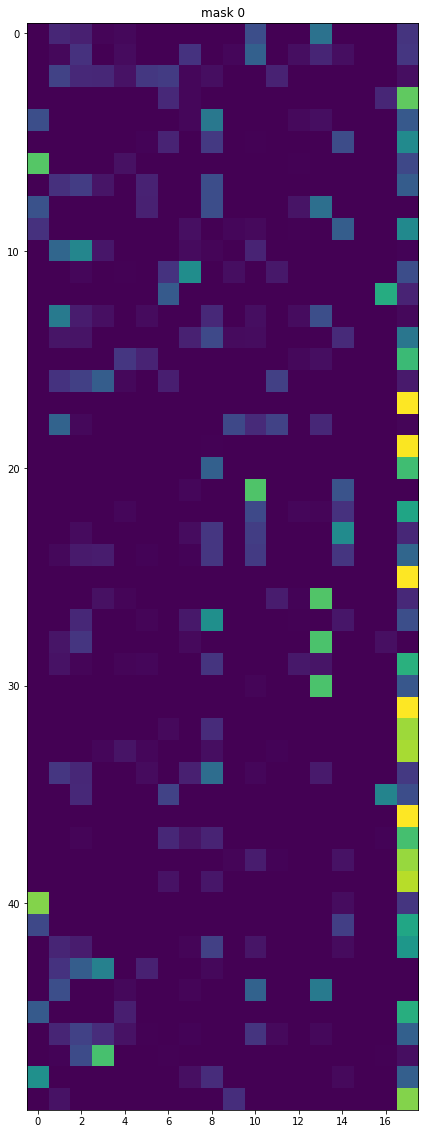

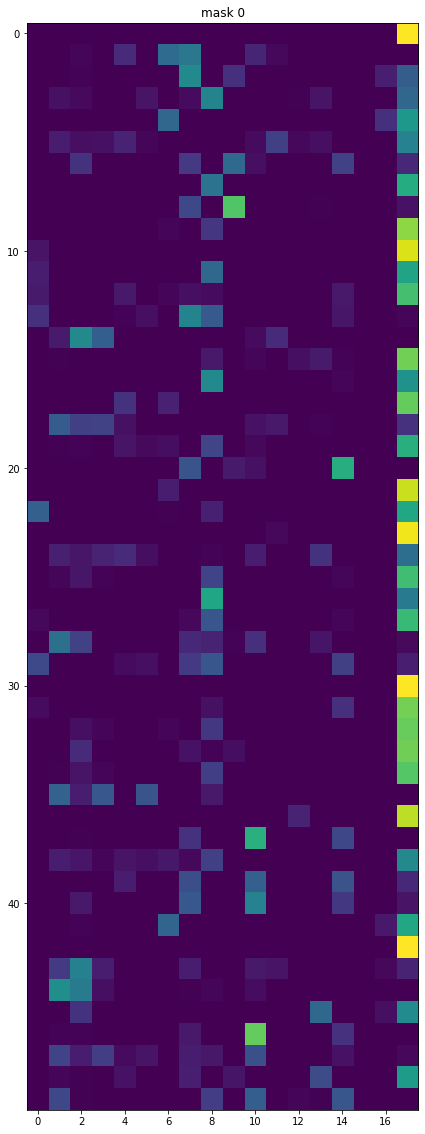

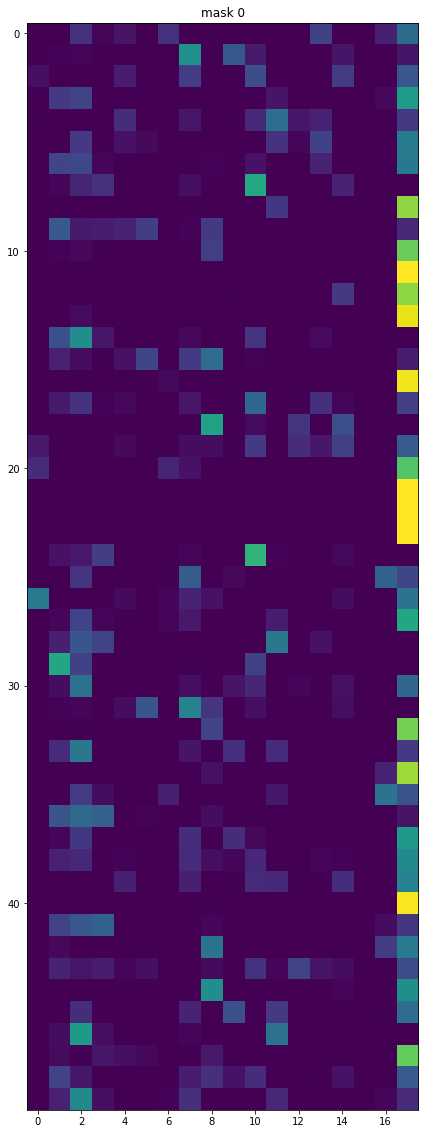

In [ ]:
explain_matrix, masks = Classifier.explain(test_x)

fig, axs = plt.subplots(figsize=(20,20))
axs.imshow(masks[0][:50])
axs.set_title(f"mask {0}")

fig, axs = plt.subplots(figsize=(20,20))
axs.imshow(masks[0][50:100])
axs.set_title(f"mask {0}")

fig, axs = plt.subplots(figsize=(20,20))
axs.imshow(masks[0][100:150])
axs.set_title(f"mask {0}")

In [ ]:
import plotly.express as px
explainability_matrix , masks = Classifier.explain(test_x)
features = ['feature_{}'.format(i) for i in range(0, 18)]
# Normalize the importance by sample
normalized_explain_mat = np.divide(explainability_matrix, explainability_matrix.sum(axis=1).reshape(-1, 1)+1e-8)

# Add prediction to better understand correlation between features and predictions
val_preds = np.array(Classifier.predict(test_x))

explain_and_preds = np.hstack([normalized_explain_mat, val_preds.reshape(-1, 1)])
from matplotlib import pyplot as plt
%matplotlib inline
px.imshow(explain_and_preds[:,:],
          labels=dict(x="Features", y="Samples", color="Importance"),
          x=features+["prediction"],
          title="Sample wise feature importance",
          color_continuous_scale='Jet',
          height=10000)

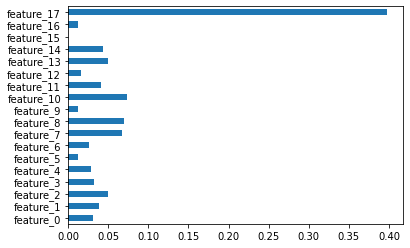

In [ ]:
feat_importances = pd.Series(Classifier.feature_importances_, index=features)
feat_importances.plot(kind='barh')

##SHAP With XGBoost and pycaret

In [ ]:
!pip install shap
import numpy as np
from xgboost import XGBClassifier
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.3 MB/s 


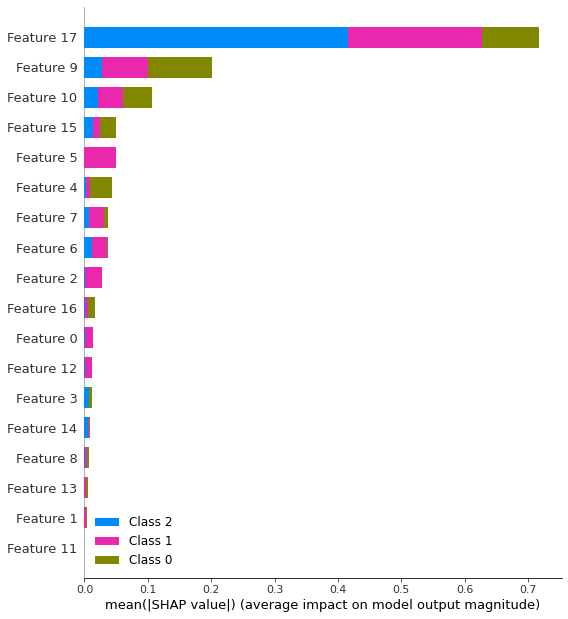

In [ ]:
model = XGBClassifier()
model.fit(train_x, train_y, eval_metric="mlogloss")
y_pred = model.predict(train_x)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, train_x, plot_type="bar")

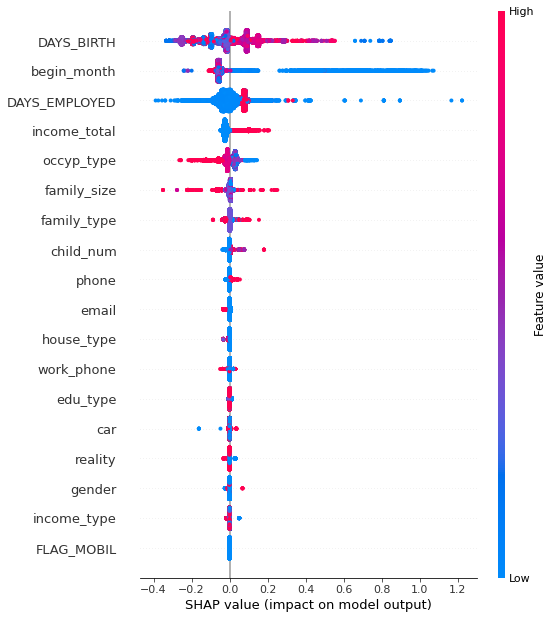

In [ ]:
shap.summary_plot(shap_values[0], train_x, feature_names = train.columns)

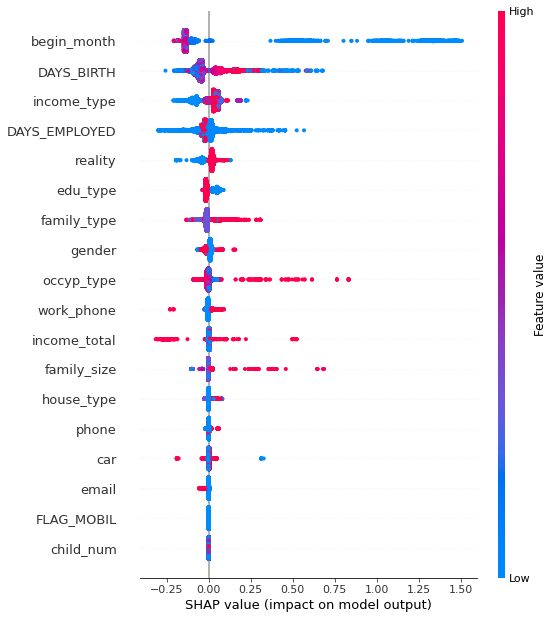

In [ ]:
shap.summary_plot(shap_values[1], train_x, feature_names = train.columns)

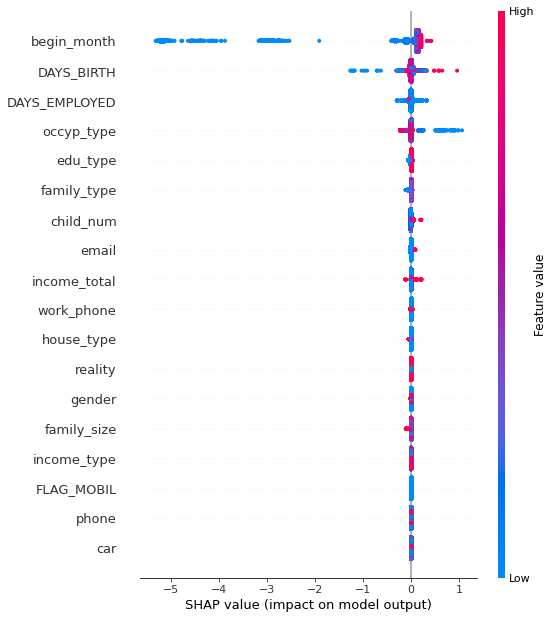

In [ ]:
shap.summary_plot(shap_values[2], train_x, feature_names = train.columns)

In [8]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov  1 01:37:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [10]:
data=data.drop(['FLAG_MOBIL'],axis=1)

In [11]:
train=data[:len(data)-10000]
test=data[len(data)-10000:]
columns=train.columns
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test.drop('credit', axis=1)

In [12]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in tqdm(train_x.columns):
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train_x[col].nunique())
        l_enc = LabelEncoder()
        train_x[col] = train_x[col].fillna("NaN")
        train_x[col] = l_enc.fit_transform(train_x[col].values)
        try:
            test_x[col] = test_x[col].fillna("NaN")
            test_x[col] = l_enc.transform(test_x[col].values)
        except:
            print(f"Column {col} does not exist in test set")
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        training_mean = train_x.loc[train_x.index, col].mean()
        train.fillna(training_mean, inplace=True)
        test.fillna(training_mean, inplace=True)

  0%|          | 0/17 [00:00<?, ?it/s]

gender 2
car 2
reality 2
child_num 9
income_total 7
income_type 5
edu_type 5
family_type 5
house_type 6
work_phone 2
phone 2
email 2
occyp_type 19
family_size 10
begin_month 61


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [13]:
features = [ col for col in train_x.columns] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]
cat_cols = [ f for i, f in enumerate(features) if f in categorical_columns]

In [14]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
accuracy=[]
for train_idx, valid_idx in skfold.split(train_x, train_y):
        folds.append((train_idx, valid_idx))

for fold in range(5):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = train_x.iloc[train_idx], train_x.iloc[valid_idx], train_y.iloc[train_idx], train_y.iloc[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)
  model_cat = CatBoostClassifier()
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  C = model_cat.predict(X_valid)
  C=list(map(float, C))
  C=list(map(int, C))
  accuracy.append(accuracy_score(y_valid.values.flatten(),C))
print(np.mean(accuracy))


----------------- Fold 0 -----------------

Learning rate set to 0.114773
0:	learn: 1.0356216	test: 1.0348746	best: 1.0348746 (0)	total: 123ms	remaining: 2m 2s


KeyboardInterrupt: ignored

##Catboost With Optuna

In [ ]:
from sklearn.model_selection import train_test_split

def objective(trial):
  param = {
      "random_state":42,
      'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
      'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
      "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
      "max_depth":trial.suggest_int("max_depth", 4, 16),
      'random_strength' :trial.suggest_int('random_strength', 0, 100),
      "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
      "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
      "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
      "max_bin": trial.suggest_int("max_bin", 200, 500),
      'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
  }

  skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  folds=[]
  accuracy=[]
  for train_idx, valid_idx in skfold.split(train_x, train_y):
        folds.append((train_idx, valid_idx))

  for fold in range(5):
    print(f'\n----------------- Fold {fold} -----------------\n')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = train_x.iloc[train_idx], train_x.iloc[valid_idx], train_y.iloc[train_idx], train_y.iloc[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)
    model_cat = CatBoostClassifier()
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
    C = model_cat.predict(X_valid)
    C=list(map(float, C))
    C=list(map(int, C))
    accuracy.append(accuracy_score(y_valid.values.flatten(),C))
  return np.mean(accuracy)
  
study = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'maximize')
study.optimize(objective, n_trials=10)
print("Best Score:",study.best_value)
print("Best trial",study.best_trial.params)

[I 2022-11-01 01:41:21,499] A new study created in memory with name: cat_parameter_opt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  import sys



----------------- Fold 0 -----------------

Learning rate set to 0.114773
0:	learn: 1.0356216	test: 1.0348746	best: 1.0348746 (0)	total: 68.6ms	remaining: 1m 8s
100:	learn: 0.7882616	test: 0.7975007	best: 0.7975007 (100)	total: 5.81s	remaining: 51.7s
200:	learn: 0.7604393	test: 0.7892599	best: 0.7892599 (200)	total: 12.3s	remaining: 49.1s
300:	learn: 0.7369904	test: 0.7851175	best: 0.7851175 (300)	total: 18.9s	remaining: 44s
400:	learn: 0.7162040	test: 0.7821683	best: 0.7821645 (398)	total: 25.3s	remaining: 37.9s
500:	learn: 0.6955521	test: 0.7783631	best: 0.7782675 (498)	total: 31.8s	remaining: 31.6s
600:	learn: 0.6759639	test: 0.7752358	best: 0.7752202 (599)	total: 38.2s	remaining: 25.3s
700:	learn: 0.6567212	test: 0.7736723	best: 0.7734763 (688)	total: 44.7s	remaining: 19.1s
800:	learn: 0.6375751	test: 0.7713125	best: 0.7712148 (797)	total: 52.2s	remaining: 13s
900:	learn: 0.6200178	test: 0.7689127	best: 0.7688407 (898)	total: 59.1s	remaining: 6.49s
999:	learn: 0.6035456	test: 0.76

[I 2022-11-01 01:46:45,759] Trial 0 finished with value: 0.6970555827698686 and parameters: {'learning_rate': 0.17241318449468768, 'bagging_temperature': 0.01789388563106166, 'n_estimators': 2993, 'max_depth': 11, 'random_strength': 64, 'colsample_bylevel': 0.9968823029655901, 'l2_leaf_reg': 1.7539819808349992e-05, 'min_child_samples': 14, 'max_bin': 234, 'od_type': 'Iter'}. Best is trial 0 with value: 0.6970555827698686.


999:	learn: 0.5957442	test: 0.7762593	best: 0.7759728 (956)	total: 1m 2s	remaining: 0us

bestTest = 0.7759728304
bestIteration = 956

Shrink model to first 957 iterations.

----------------- Fold 0 -----------------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  import sys


Learning rate set to 0.114773
0:	learn: 1.0356216	test: 1.0348746	best: 1.0348746 (0)	total: 64.1ms	remaining: 1m 4s
100:	learn: 0.7882616	test: 0.7975007	best: 0.7975007 (100)	total: 5.54s	remaining: 49.3s
200:	learn: 0.7604393	test: 0.7892599	best: 0.7892599 (200)	total: 11.8s	remaining: 46.9s
300:	learn: 0.7369904	test: 0.7851175	best: 0.7851175 (300)	total: 18.2s	remaining: 42.3s
400:	learn: 0.7162040	test: 0.7821683	best: 0.7821645 (398)	total: 24.4s	remaining: 36.5s
500:	learn: 0.6955521	test: 0.7783631	best: 0.7782675 (498)	total: 30.7s	remaining: 30.6s
600:	learn: 0.6759639	test: 0.7752358	best: 0.7752202 (599)	total: 37s	remaining: 24.6s
700:	learn: 0.6567212	test: 0.7736723	best: 0.7734763 (688)	total: 43.4s	remaining: 18.5s
800:	learn: 0.6375751	test: 0.7713125	best: 0.7712148 (797)	total: 49.7s	remaining: 12.3s
900:	learn: 0.6200178	test: 0.7689127	best: 0.7688407 (898)	total: 56.1s	remaining: 6.17s
999:	learn: 0.6035456	test: 0.7685463	best: 0.7684983 (996)	total: 1m 2s	re

#AutoEncoder With Shap